# Feature Encoding Comparison

For this study, multiple methods for encoding categorical features with high cardinality will be tested and compared. Each encoding method will be evaluated against multiple predictive models.

These encoding methods will be tested: 
- Multiple Correspondence Analysis (MCA)
- K-Modes clustering
- James Stein target encoding
- M-Measure encoding
- CatBoost encoding

The following predictive models will be used to evaluate the encoding methods:
- CatBoost
- Random Forest
- Gradient Boost
- XGBoost

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import *
from sklearn.metrics import accuracy_score
from scipy.cluster.vq import kmeans, vq
from scipy import stats
from scipy.stats import shapiro
from sklearn import linear_model
from statsmodels.graphics.gofplots import qqplot
from kmodes.kmodes import KModes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import prince
from category_encoders.cat_boost import CatBoostEncoder
from category_encoders import JamesSteinEncoder
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
import statsmodels.api as sm
from statsmodels.formula.api import ols

import matplotlib as mpl
import seaborn as sb

# Silence future and user warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Nicer looking style for seaborn
plt.style.use('classic')
sb.set(style="white")
mpl.rc('scatter', edgecolors='none')

Within the dataset there was a natural disaster which occurred that had an impact on the pricing of houses in the area from which the data was collected. A wildfire in 2017 wiped out over 3,000 houses in Sonoma County. A quick analysis is included in this study to evaluate the impact the fires had on house prices.

In [2]:
# Date range for natural disaster that may impact data consistency
fires_start = datetime.datetime(2017, 10, 8)
fires_end = datetime.datetime(2017, 10, 31)

# Data Preparation

In [3]:
# Load the dataset and clean up column names
original_data = pd.read_csv('housingData.csv', 
                            index_col=0, parse_dates=['Sold Date'])

# Remove special characters from column names
original_data.columns = original_data.columns.str.replace(' ', '').str.replace('/','').str.replace('.','')
original_data.head()

C:\Users\thebr\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (116) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,StreetAddress,MLS,PropertyType,SubType,ListingStatus,ListingPrice,CountyArea,ZipCode,YearBuilt,SqFt,...,YearRatedGreen,FireplaceDetails,ViewDetails,Location,SubdivDeveloper,UnitBlkLot,WellDepth,OpenHouse,2ndUnitHalfBaths,PoolDetails
0,2321 Sophia Drive,21918929,Single Family Home,Single Family Residence,Sold,"$535,000",Sonoma County,95403.0,2006.0,"1,919 sq ft",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,180 Courtyards E,21913013,Condo/Townhouse,Condo/Coop,Sold,"$325,000",Sonoma County,95492.0,1987.0,980 sq ft,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1320 North Street #26,21907815,Condo/Townhouse,Condo/Coop,Sold,"$419,000",Sonoma County,95409.0,1980.0,"1,382 sq ft",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1308 Mission Boulevard,21825722,Condo/Townhouse,Condo/Coop,Sold,"$299,000",Sonoma County,95409.0,1987.0,"1,188 sq ft",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6065 Elsa Avenue,21824170,Single Family Home,Single Family Residence,Sold,"$635,000",Sonoma County,94928.0,1974.0,"2,226 sq ft",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The dataset initially contains 116 different columns, many of which are categorical in nature.

In [5]:
original_data.columns.to_list()

['StreetAddress',
 'MLS',
 'PropertyType',
 'SubType',
 'ListingStatus',
 'ListingPrice',
 'CountyArea',
 'ZipCode',
 'YearBuilt',
 'SqFt',
 'Style',
 'Stories',
 'TotalRooms',
 'Bedrooms',
 'FullBaths',
 'Garage',
 'Fireplace',
 'LotSize',
 'Baths',
 'Area',
 '#OffStreetSpaces',
 'AttachDetachHome',
 'ConstructCondition',
 'ConstructionType',
 'Exterior',
 'HeatCool',
 'LaundryAppliance',
 'LotDescription',
 'LotMeasurement',
 'LotSize[SqFt]',
 'Roof',
 'SaleLease-Rent',
 'SewerSeptic',
 'SquareFootageSource',
 'StatusDate',
 'Utilities',
 'WaterSource',
 'YearBuiltSource',
 'SoldDate',
 'SoldPrice',
 'SchoolDistrict',
 'PoolorSpa',
 'BathType',
 'CommRec',
 'CommonIntDev',
 'DiningRoom',
 'DriveSidewalk',
 'FeeIncludes',
 'Fencing',
 'Floors',
 'HOA',
 'HOAAmount',
 'HOAName',
 'HOAPaid',
 'Kitchen',
 'LivingRoom',
 'LocationofUnit',
 'MainLevel',
 'PlannedUnitDevelop',
 'UpperLevel',
 'YardGrounds',
 'ElementarySchool',
 'MiddleSchool',
 'HighSchool',
 'HalfBaths',
 'Foundation',
 '

In [ ]:
# Removing records that are missing critical fields
original_data = original_data[~(original_data.ListingStatus.isnull()) & 
                              ~(original_data.ZipCode.isnull()) &
                              ~(original_data.PropertyType.isnull()) &
                              ~(original_data.SqFt.isnull())]
original_data = original_data.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# Data cleaning and formatting
original_data.Senior.replace({'Yes':1, np.nan: 0}, inplace=True)
original_data.SpaHotTubYN.replace({'Yes':1, np.nan: 0}, inplace=True)
original_data.HOA.replace({'Yes':1, np.nan: 0}, inplace=True)
original_data['ZipCode'] = original_data.ZipCode.astype(int)
original_data['ListingPrice'] = original_data.ListingPrice.replace(\
                                    '[\$,]', '', regex=True).astype(float)
original_data['SoldPrice'] = original_data.SoldPrice.replace(\
                                    '[\$,]', '', regex=True).astype(float)
original_data['SqFt'] = original_data.SqFt.replace(\
                                    '[sqft.,]', '', regex=True).astype(int)
original_data['Garage'] = original_data.Garage.replace(\
                                    '[\-Car]', '', regex=True).astype(float)
original_data['OffStreetSpaces'] = original_data.OffStreetSpaces.replace(\
                                    '[\+]', '', regex=True).astype(float)

In [6]:
# Create index of columns with high ratio of missing values
null_counts = original_data.isna().mean()
null_counts = list(null_counts[null_counts > 0.7].index)

In [7]:
# Review columns with high ratio of missing values
print(len(null_counts))
print(null_counts)

# List of columns to keep after manual review of column significance
keep_list = list(['SchoolDistrict', 'PoolorSpa', 'CommRec', 'LocationofUnit', 'EnergyConservation'])

54
['SchoolDistrict', 'PoolorSpa', 'CommRec', 'CommonIntDev', 'FeeIncludes', 'LocationofUnit', 'PlannedUnitDevelop', 'ElementarySchool', 'MiddleSchool', 'HighSchool', 'Miscellaneous', 'PubTransportation', 'UpgradeNewConOnly', 'FamilyRoom', 'LowerLevel', '2ndUnitBdrms', '2ndUnitFullBaths', '2ndUnitKitchen', '2ndUnitOccupied', '2ndUnitRentsfor', '2ndUnitType', '2ndUnitonLot', 'EnergyConservation', 'Irrigation', 'Drainage', 'Accessibility', 'NewConstruction', 'Restrictions', 'Zoning', 'Soil', 'SubdivisionNeighborhood', 'Waterfront', 'HeightLimit', 'HomeProtectionPlan', '2ndUnitApproxSqFt', 'Furnished', 'BuilderArchitect', 'ModelName', 'TotalUnitsinSubd', 'WellGPM', 'Units', '#DifferentModels', 'GreenRatedbyWhom?', 'GreenRating', 'YearRatedGreen', 'FireplaceDetails', 'ViewDetails', 'Location', 'SubdivDeveloper', 'UnitBlkLot', 'WellDepth', 'OpenHouse', '2ndUnitHalfBaths', 'PoolDetails']


In [8]:
# Remove columns with high ratio of missing values
null_counts = list(set(null_counts) - set(keep_list))
original_data = original_data.drop(null_counts, axis=1)
original_data.head()

,StreetAddress,MLS,PropertyType,SubType,ListingStatus,ListingPrice,CountyArea,ZipCode,YearBuilt,SqFt,...,YardGrounds,HalfBaths,Foundation,GarageParking,SpaHotTubYN,OtherRooms,Senior,OtherStructures,View,EnergyConservation
0,2321 Sophia Drive,21918929,Single Family Home,Single Family Residence,Sold,535000.0,Sonoma County,95403,2006.0,1919,...,NaN,NaN,NaN,NaN,0,NaN,0,NaN,NaN,NaN
1,180 Courtyards E,21913013,Condo/Townhouse,Condo/Coop,Sold,325000.0,Sonoma County,95492,1987.0,980,...,Landscaped- Rear,NaN,NaN,NaN,0,NaN,0,NaN,NaN,NaN
2,1320 North Street #26,21907815,Condo/Townhouse,Condo/Coop,Sold,419000.0,Sonoma County,95409,1980.0,1382,...,"Landscaped- Front, Landscaped- Rear, Patio(s)",1.0,Concrete Perimeter,"2 Car, Attached, Guest Accommodations",1,NaN,0,NaN,NaN,NaN
3,1308 Mission Boulevard,21825722,Condo/Townhouse,Condo/Coop,Sold,299000.0,Sonoma County,95409,1987.0,1188,...,NaN,1.0,NaN,"2 Car, Tandem, Off Street, Assigned, Guest Acc...",1,NaN,0,NaN,NaN,NaN
4,6065 Elsa Avenue,21824170,Single Family Home,Single Family Residence,Sold,635000.0,Sonoma County,94928,1974.0,2226,...,NaN,NaN,NaN,"2 Car, Attached",0,"Den/Study, Guest Suite",0,NaN,NaN,NaN


In [ ]:
# Exporting data for LaTeX
with open('originaldata.tex','w') as tf:
    tf.write(original_data.head(2).transpose().to_latex())

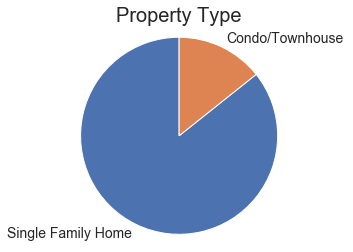

In [9]:
type_counts = original_data['PropertyType'].value_counts()
type_labels = original_data['PropertyType'].unique()
plt.pie(type_counts, labels=type_labels, startangle=90, textprops={'fontsize': 14})
plt.title("Property Type", fontdict={'fontsize': 20})
plt.axis('equal')
plt.show()

In [10]:
# Import data from Redfin
redfin_data = pd.read_csv('data_data.csv', parse_dates=['Period End'])
redfin_data.columns = redfin_data.columns.str.replace(' ', '')
redfin_data.head()

,AvgSaleToList,AvgSaleToListMom,AvgSaleToListYoy,HomesSold,HomesSoldMom,HomesSoldYoy,Inventory,InventoryMom,InventoryYoy,SeasonallyAdjusted,...,MedianSalePriceMom,MedianSalePriceYoy,NewListings,NewListingsMom,NewListingsYoy,PeriodEnd,PropertyType,Region,RegionType,StateCode
0,0.986036,1.0%,0.8%,563,10.5%,21.9%,1574,-5.7%,-22.7%,True,...,3.6%,0.0%,587,3.3%,-11.2%,2012-01-31,All Residential,"Sonoma County, CA",County,CA
1,0.983811,-0.2%,0.8%,497,-11.7%,1.7%,1511,-4.0%,-24.5%,True,...,1.6%,-0.2%,555,-5.4%,-13.6%,2012-02-29,All Residential,"Sonoma County, CA",County,CA
2,0.981297,-0.3%,0.3%,539,8.5%,13.9%,1355,-10.3%,-31.4%,True,...,-3.0%,3.1%,503,-9.4%,-3.3%,2012-03-31,All Residential,"Sonoma County, CA",County,CA
3,0.978953,-0.2%,0.3%,508,-5.7%,13.5%,1191,-12.1%,-41.3%,True,...,5.6%,6.9%,497,-1.2%,-24.8%,2012-04-30,All Residential,"Sonoma County, CA",County,CA
4,0.988914,1.0%,1.8%,510,0.3%,24.3%,1136,-4.6%,-43.9%,True,...,-6.7%,-2.3%,553,11.3%,-5.8%,2012-05-31,All Residential,"Sonoma County, CA",County,CA


In [ ]:
# Exporting table for LaTeX
with open('redfin.tex','w') as tf:
    tf.write(redfin_data.head(3).transpose().to_latex())

In [11]:
string_cols = redfin_data.select_dtypes(include='O')
percent = []
for column in string_cols.columns:
    if string_cols[column].str.contains("%").any():
        percent+=[column]
percent

for percol in percent:
    redfin_data[percol] = redfin_data[percol].str.strip('%').astype('float')/100

In [12]:
redfin_data['MedianSalePrice'] = redfin_data['MedianSalePrice'].str.replace('[\$K]', '', regex=True).astype('float') * 1000

In [13]:
combined_data = pd.merge(original_data.assign(grouper=original_data['SoldDate'].dt.to_period('M')), 
                         redfin_data.assign(grouper=redfin_data['PeriodEnd'].dt.to_period('M')+1),
                         how='left', on='grouper')

combined_data = combined_data.drop(['PeriodEnd', 'grouper', 'StateCode', 'SeasonallyAdjusted', 'StatusDate',
                                    'SaleLease-Rent', 'StreetAddress', 'MLS', 'SubType', 'HOAName',
                                    'RegionType', 'Region', 'PropertyType_y', 'ListingStatus', 'CountyArea',
                                    'YearBuiltSource', 'SquareFootageSource', 'LotMeasurement'], axis=1)
combined_data.drop('LotSize', axis=1, inplace=True)
combined_data.rename(columns={'PropertyType_x':'PropertyType', 
                              '#OffStreetSpaces': 'OffStreetSpaces',
                              'LotSize[SqFt]':'LotSize'}, inplace=True)

In [8]:
combined_data.to_csv('combinedData.csv')
# Remove price outliers by only retaining records that have a zscore of 3 or less
cleaned_data = combined_data[stats.zscore(combined_data.SoldPrice) <= 3]

# Explorative Data Analysis

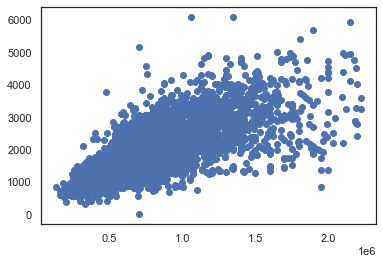

In [9]:
plt.scatter(cleaned_data.SoldPrice, cleaned_data.SqFt)

In [10]:
cleaned_data.SqFt.min()

1

In [11]:
cleaned_data = cleaned_data[cleaned_data.SqFt > 1]

<AxesSubplot:>

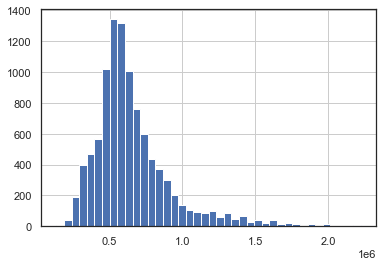

In [12]:
cleaned_data.SoldPrice.hist(bins=40)

Statistic=0.852, p-value=0.00000000000000000000000000000000000000000000000000


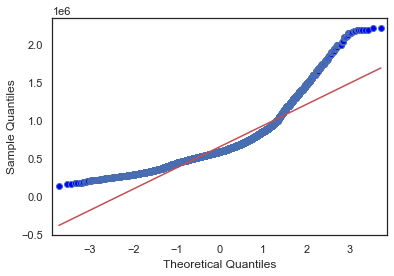

In [13]:
# Testing for normality of distribution of house sold prices
stat, p = shapiro(cleaned_data.SoldPrice)
print('Statistic=%.3f, p-value=%.50f' % (stat, p))
    
qqplot(cleaned_data.SoldPrice, line='s')
plt.show()

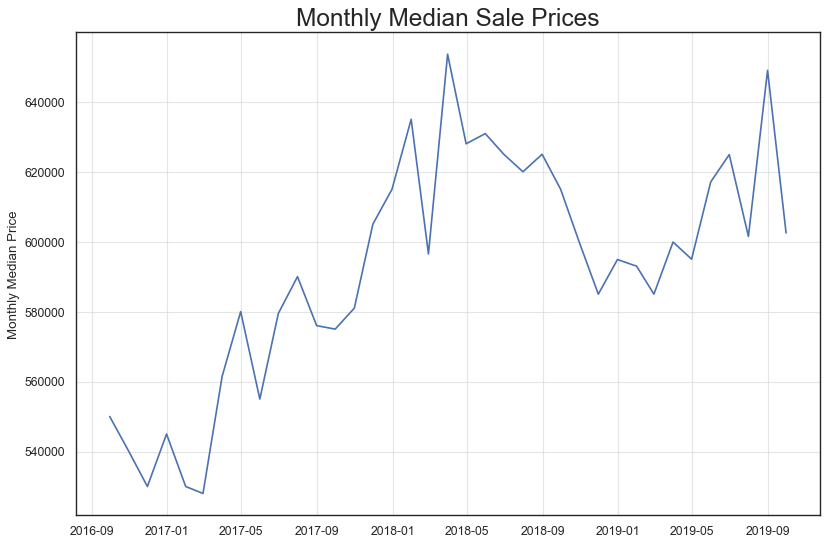

In [19]:
# Plot the median sold price by month
median_soldprice = cleaned_data.SoldPrice.groupby([cleaned_data.SoldDate.dt.year, cleaned_data.SoldDate.dt.month]).median()
error_range = pd.date_range(cleaned_data.SoldDate.min(), cleaned_data.SoldDate.max() + pd.DateOffset(months=1), freq='M')

plt.figure(figsize=(12,8), dpi= 80)
plt.plot(error_range, median_soldprice)
plt.ylabel('Monthly Median Price')
plt.title("Monthly Median Sale Prices", fontsize=22)
plt.grid(alpha=0.5)
plt.show()

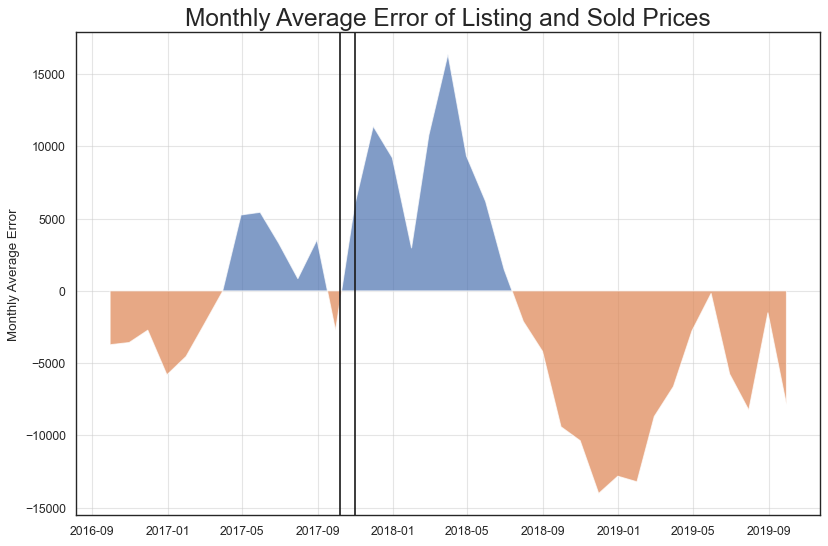

In [20]:
# Plot the average monthly variance in listing price versus sold price
temp_data = cleaned_data.SoldPrice - cleaned_data.ListingPrice
average_error = temp_data.groupby([cleaned_data.SoldDate.dt.year, cleaned_data.SoldDate.dt.month]).mean()
error_range = pd.date_range(cleaned_data.SoldDate.min(), cleaned_data.SoldDate.max() + pd.DateOffset(months=1), freq='M')
prior_errors = pd.DataFrame(average_error).assign(D=error_range)

plt.figure(figsize=(12,8), dpi= 80)
plt.fill_between(error_range, average_error, 0, where=average_error >= 0, interpolate=True, alpha=0.7)
plt.fill_between(error_range, average_error, 0, where=average_error <= 0, interpolate=True, alpha=0.7)
# Identify time range of natural distaster to account for possible impact on data
plt.axvline(x=fires_start, color='k', linestyle='-')
plt.axvline(x=fires_end, color='k', linestyle='-')
plt.ylabel('Monthly Average Error')
plt.title("Monthly Average Error of Listing and Sold Prices", fontsize=22)
plt.grid(alpha=0.5)
plt.show()

In [21]:
preFirePrices = cleaned_data.SoldPrice[cleaned_data.SoldDate < fires_start]
postFirePrices = cleaned_data.SoldPrice[cleaned_data.SoldDate > fires_end]

W=0.847, p-value=0.00000


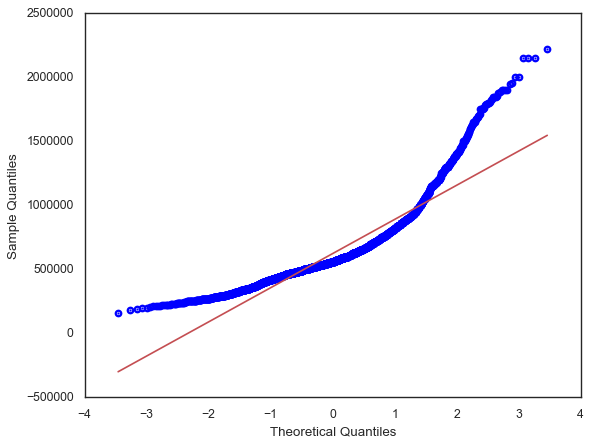

W=0.851, p-value=0.00000


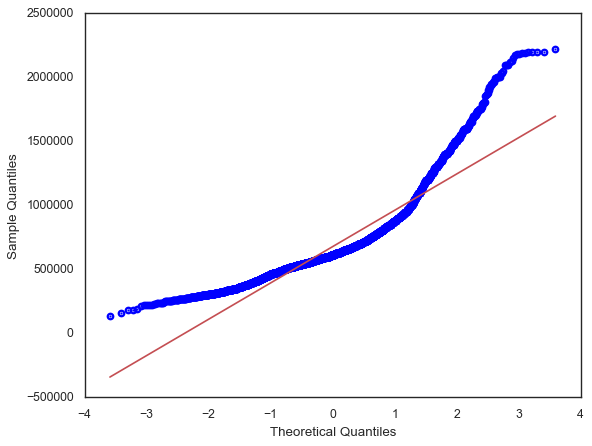

In [31]:
# Quantile of quantiles plots and Shapiro-Wilk test for Normality
preFirePrices = cleaned_data.SoldPrice[cleaned_data.SoldDate < fires_start]
postFirePrices = cleaned_data.SoldPrice[cleaned_data.SoldDate > fires_end]

stat, p = shapiro(preFirePrices)
print('W=%.3f, p-value=%.5f' % (stat, p))

fig = qqplot(preFirePrices, line='s', markerfacecolor='blue', mew=5, markersize=2, markeredgecolor='blue', marker='o')
plt.show()

stat, p = shapiro(postFirePrices)
print('W=%.3f, p-value=%.5f' % (stat, p))

qqplot(postFirePrices, line='s', markerfacecolor='blue', mew=5, markersize=2, markeredgecolor='blue', marker='o')
plt.show()

In [32]:
mpl.rcParams["scatter.edgecolors"] = 'none'
mpl.rc('figure', edgecolor='k')

Since the assumptions of normality were not met, Levene and Kruskal-Wallis tests for variance between samples of before and after the fires.

Levene Statistic=6.094, p-value=0.01358
Kruskal Statistic=154.230, p-value=0.00000


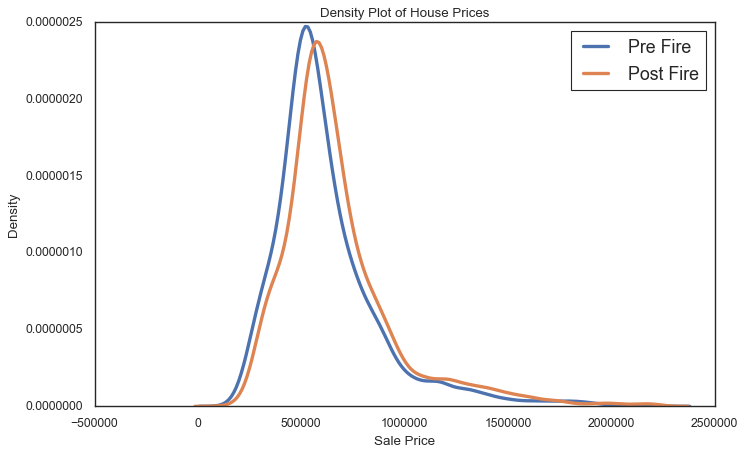

In [34]:
# Calculate Levene and Kruskal statistics for one-way non-parametric ANOVA
plt.figure(figsize=(10, 6))
stat, p = stats.levene(preFirePrices, postFirePrices)
print('Levene Statistic=%.3f, p-value=%.5f' % (stat, p))
stat, p = stats.kruskal(preFirePrices, postFirePrices)
print("Kruskal Statistic=%.3f, p-value=%.5f" % (stat, p))

# Overlapping distribution plots of house prices from before and after the fires
sb.distplot(preFirePrices, hist = False, kde = True,
                 kde_kws = {'shade': False, 'linewidth': 3},
                 label = 'Pre Fire', )
sb.distplot(postFirePrices, hist = False, kde = True,
                 kde_kws = {'shade': False, 'linewidth': 3},
                 label = 'Post Fire')

# Plot formatting
plt.legend(prop={'size': 16})
plt.title('Density Plot of House Prices')
plt.xlabel('Sale Price')
plt.ylabel('Density')
plt.show()

In [35]:
null_counts = len(cleaned_data) - cleaned_data.count()
null_counts[null_counts > 0]

YearBuilt               42
Style                 1029
Stories                 19
TotalRooms            3452
Bedrooms                 5
FullBaths                3
Garage                1249
Fireplace             2021
Baths                    2
OffStreetSpaces       5902
ConstructionType       415
Exterior               444
HeatCool                94
LaundryAppliance       177
LotDescription         255
LotSize                262
Roof                  3156
SewerSeptic             90
Utilities               74
WaterSource             20
SchoolDistrict        8561
PoolorSpa             7982
BathType              3851
CommRec               8528
DiningRoom            3612
DriveSidewalk         4701
Fencing               4052
Floors                2699
HOAAmount             6876
HOAPaid               6875
Kitchen               2429
LivingRoom            5167
LocationofUnit        8908
MainLevel             3601
UpperLevel            6541
YardGrounds           4801
HalfBaths             6709
F

In [36]:
# Identifying categorical/nominal variables and continuous variables
continuous = ['ListingPrice', 'YearBuilt', 'SqFt', 'LotSize', 'SoldPrice', 'AvgSaleToList',
              'HomesSold', 'HomesSoldMom', 'HomesSoldYoy', 'Inventory', 'InventoryMom', 
              'InventoryYoy', 'MedianSalePriceMom', 'MedianSalePriceYoy', 'NewListings', 
              'NewListingsMom', 'NewListingsYoy', 'MedianDomYoy', 'MedianDomMom', 
              'MedianSalePrice', 'AvgSaleToListYoy', 'FullBaths', 'MedianDom', 'HOAAmount',
              'AvgSaleToListMom', 'TotalRooms', 'Baths']

categorical = ['ZipCode', 'ConstructCondition', 'AttachDetachHome', 'Garage', 'LaundryAppliance', 
               'SpaHotTubYN', 'SoldDate', 'HOA', 'HOAPaid', 'OtherRooms', 'DriveSidewalk', 'Bedrooms', 
               'PropertyType', 'Area', 'ConstructionType', 'View', 'OtherStructures', 'EnergyConservation', 
               'Stories', 'LivingRoom', 'OffStreetSpaces', 'Floors', 'CommRec', 'GarageParking', 
               'MainLevel', 'Style', 'HeatCool', 'Fireplace', 'BathType', 'UpperLevel', 'PoolorSpa', 
               'YardGrounds', 'SchoolDistrict', 'HalfBaths', 'Fencing', 'Exterior', 'Kitchen', 'Utilities', 
               'Roof', 'WaterSource', 'SewerSeptic', 'LocationofUnit', 'Foundation', 'LotDescription', 
               'DiningRoom', 'CountyArea', 'Senior']

In [24]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(cleaned_data.nunique())

PropertyType             2
ListingPrice          1471
ZipCode                 16
YearBuilt              140
SqFt                  2260
Style                  210
Stories                 25
TotalRooms              16
Bedrooms                 9
FullBaths                6
Garage                  12
Fireplace              688
Baths                    7
Area                    11
OffStreetSpaces         15
AttachDetachHome         2
ConstructCondition       3
ConstructionType        16
Exterior               104
HeatCool               937
LaundryAppliance       413
LotDescription         528
LotSize               2923
Roof                    47
SewerSeptic             25
Utilities              909
WaterSource             66
SoldDate               802
SoldPrice             1808
SchoolDistrict         310
PoolorSpa              207
BathType               741
CommRec                546
DiningRoom              69
DriveSidewalk           48
Fencing                 97
Floors                 452
H

# Encoding Methods

In [25]:
# M-Measure target encoding function
def smooth_target_clust(data, category, target, weight):
    t_mean = data[target].mean()
    grouped = data[[category, target]].groupby(category)[target].aggregate(['count', 'mean'])
    c_means = grouped['mean']
    counts = grouped['count']
    smooth = (c_means * counts + t_mean * weight) / (counts + weight)
    data[category] = data[category].map(smooth)

In [26]:
def kmodes_cats(source_cat, categories, cluster_count=5, prefix='cluster'):
    km = KModes(n_clusters=cluster_count, init='Huang', n_init=cluster_count, verbose=0)
    clusters = km.fit_predict(categories)
    cluster_dict = {}
    for i in range(0,cluster_count):
        cluster_dict[str(prefix+str(i))] = source_cat[clusters == i].unique()
    clusters = pd.get_dummies(clusters, prefix=prefix)
    return cluster_dict, clusters

In [27]:
string_cols = cleaned_data.select_dtypes(include='O')

In [28]:
comma_cols = []
for column in string_cols.columns:
    if string_cols[column].str.contains(",").any():
        comma_cols+=[column]
comma_cols

['Style',
 'Stories',
 'Fireplace',
 'ConstructionType',
 'Exterior',
 'HeatCool',
 'LaundryAppliance',
 'LotDescription',
 'Roof',
 'SewerSeptic',
 'Utilities',
 'WaterSource',
 'SchoolDistrict',
 'PoolorSpa',
 'BathType',
 'CommRec',
 'DiningRoom',
 'DriveSidewalk',
 'Fencing',
 'Floors',
 'Kitchen',
 'LivingRoom',
 'LocationofUnit',
 'MainLevel',
 'UpperLevel',
 'YardGrounds',
 'Foundation',
 'GarageParking',
 'OtherRooms',
 'OtherStructures',
 'View',
 'EnergyConservation']

In [37]:
null_counts = len(cleaned_data) - cleaned_data.count()
null_counts[null_counts > 0]

YearBuilt               42
Style                 1029
Stories                 19
TotalRooms            3452
Bedrooms                 5
FullBaths                3
Garage                1249
Fireplace             2021
Baths                    2
OffStreetSpaces       5902
ConstructionType       415
Exterior               444
HeatCool                94
LaundryAppliance       177
LotDescription         255
LotSize                262
Roof                  3156
SewerSeptic             90
Utilities               74
WaterSource             20
SchoolDistrict        8561
PoolorSpa             7982
BathType              3851
CommRec               8528
DiningRoom            3612
DriveSidewalk         4701
Fencing               4052
Floors                2699
HOAAmount             6876
HOAPaid               6875
Kitchen               2429
LivingRoom            5167
LocationofUnit        8908
MainLevel             3601
UpperLevel            6541
YardGrounds           4801
HalfBaths             6709
F

In [38]:
k_cleaned_data = cleaned_data.copy()

In [31]:
prep_data = cleaned_data.copy()

prep_data.drop('HOAPaid', axis=1, inplace=True)
prep_data = prep_data.reset_index(drop=True)
prep_data.HOAAmount.fillna(0, inplace=True)
null_counts = len(prep_data) - prep_data.count()

target_cols = comma_cols + ['ZipCode', 'Area']
null_cols = null_counts[null_counts > 0].index
null_cols = set(null_cols) - set(target_cols)

for column in null_cols:
    prep_data[column].fillna(prep_data[column].median(), inplace=True)

propTypeClus = prep_data.PropertyType.str.get_dummies()
propTypeClus.reset_index(drop=True, inplace=True)
prep_data.drop('PropertyType', axis=1, inplace=True)
prep_data.reset_index(drop=True, inplace=True)
prep_data = prep_data.join(propTypeClus)

AttachDetachHomeClus = prep_data.AttachDetachHome.str.get_dummies()
AttachDetachHomeClus.reset_index(drop=True, inplace=True)
prep_data.drop('AttachDetachHome', axis=1, inplace=True)
prep_data.reset_index(drop=True, inplace=True)
prep_data = prep_data.join(AttachDetachHomeClus)

prep_data.drop(['ListingPrice', 'SoldDate', 'ConstructCondition'], axis=1, inplace=True)

# Predictive Modeling

In [33]:
# Function for evaluating a model and recording the different performance metrics of that model.
def test_model(model, model_type, method, independant, dependant):
    import numpy as np
    train_features, \
    test_features, \
    train_labels, \
    test_labels = train_test_split(independant, dependant, test_size = 0.2)
    
    model.fit(train_features, train_labels)
    predictions = model.predict(test_features)
    errors = abs(np.expm1(test_labels) - np.expm1(predictions))
    rmse = np.sqrt(mean_squared_error(np.expm1(test_labels), np.expm1(predictions)))
    adjustedr2 = 1 - (1-r2_score(predictions, test_labels))*(len(dependant)-1)/(len(dependant)-independant.shape[1]-1)
    results = pd.DataFrame({"method": method,
                            "model": model_type,
                            "rmse": rmse,
                            "score": model.score(np.expm1(test_features), np.expm1(test_labels)),
                            "adjr2": adjustedr2,
                            "mae": np.mean(errors)
                           }, index=[0])
    print(results)
    return results

In [361]:
# Evaluate each data encoding method against each model for 20 iterations
methods = ['Baseline', 'MCA', 'JamesStein', 'CatBoostEnc', 'TargetMean', 'KMode']
target_cols = comma_cols + ['ZipCode', 'Area']
train_hist = pd.DataFrame()
k_dicts = []
iterations = 20

for method in methods:
    iter_data = prep_data.copy()
    iter_data.reset_index(drop=True, inplace=True)
    if method == 'TargetMean':
        for col in target_cols:
            iter_data[col].fillna('Unknown', inplace=True)
            smooth_target_clust(iter_data, col, 'SoldPrice', 10)
    elif method == 'KMode':
        k_cols_dict = {}
        for col in target_cols:
            iter_data[col].fillna('Unknown', inplace=True)
            clus_dist, new_cols = kmodes_cats(iter_data[col], 
                                              iter_data[col].astype('str').str.get_dummies(sep=','),
                                              3, col)
            iter_data = iter_data.drop(col, axis=1)
            new_cols.reset_index(drop=True, inplace=True)
            iter_data.reset_index(drop=True, inplace=True)
            iter_data = iter_data.join(new_cols)
            k_cols_dict.update({col: clus_dist})
        k_dicts += k_cols_dict
    elif method == 'CatBoostEnc':
        for col in target_cols:
            encoder = CatBoostEncoder(handle_missing='value')
            iter_data[col] = encoder.fit_transform(iter_data[col], iter_data.SoldPrice)
    elif method == 'JamesStein':
        for col in target_cols:
            encoder = JamesSteinEncoder(return_df=False, model='independent')
            iter_data[col] = encoder.fit_transform(iter_data[col], iter_data.SoldPrice)
    elif method == 'MCA':
        iter_data[target_cols] = iter_data[target_cols].fillna('unknown')
        new_cols = pd.DataFrame()
        for col in target_cols:
            mca = prince.MCA(n_components=3, n_iter=10, check_input=True)
            mca = mca.fit(iter_data[[col]])
            clusters = mca.transform(iter_data[[col]])
            new_cols = pd.concat([new_cols, clusters], ignore_index=True)
        iter_data = iter_data.drop(target_cols, axis=1)
        new_cols.reset_index(drop=True, inplace=True)
        iter_data.reset_index(drop=True, inplace=True)
        iter_data = iter_data.join(new_cols)
    elif method == 'Baseline':
        iter_data.drop(target_cols, axis=1, inplace=True)
    
    dependant = iter_data['SoldPrice']
    dependant = np.log1p(dependant)

    independant = iter_data.drop('SoldPrice', axis=1)
    col_names = independant.columns

    sc = StandardScaler()
    independant = sc.fit_transform(independant)
    
    for i in range(iterations):

        lr = LinearRegression()
        results = test_model(lr, 'MLR', method, independant, dependant)
        train_hist = train_hist.append(results, ignore_index=True)
        
        cb = CatBoostRegressor(iterations=1000,
                               learning_rate=0.01,
                               depth=10,
                               eval_metric='RMSE',
                               verbose = False,
                               task_type="GPU",
                               devices='0:1')
        results = test_model(cb, 'CatBoost', method, independant, dependant)
        train_hist = train_hist.append(results, ignore_index=True)

        rf = RandomForestRegressor(n_estimators=1000, n_jobs = -1,
                                   max_features = "auto",
                                   max_leaf_nodes = 200)
        results = test_model(rf, 'RandomForest', method, independant, dependant)
        train_hist = train_hist.append(results, ignore_index=True)
        
        gbr = GradientBoostingRegressor(n_estimators=100, 
                                        max_features = "auto",
                                        max_leaf_nodes = 200)
        results = test_model(gbr, 'GradientBoost', method, independant, dependant)
        train_hist = train_hist.append(results, ignore_index=True)
        
        xgboost = xgb.XGBRegressor(learning_rate=0.02, n_estimators=2400,
                                   max_depth=10, min_child_weight=0,
                                   gamma=0, subsample=0.7,
                                   colsample_bytree=0.7,
                                   objective='reg:squarederror', nthread=-1,
                                   scale_pos_weight=1,
                                   reg_alpha=0.00006)
        
        results = test_model(xgboost, 'XGBoost', method, independant, dependant)
        train_hist = train_hist.append(results, ignore_index=True)

     method model           rmse     score     adjr2           mae
0  Baseline   MLR  162554.027072  0.713739  0.614099  97264.374416
     method     model           rmse     score     adjr2           mae
0  Baseline  CatBoost  145346.832426  0.801108  0.745209  84938.806656
     method         model           rmse     score     adjr2           mae
0  Baseline  RandomForest  129111.578659  0.823694  0.784938  80804.733478
     method          model           rmse     score     adjr2           mae
0  Baseline  GradientBoost  127430.713582  0.815598  0.766166  79036.397239
     method    model           rmse     score     adjr2           mae
0  Baseline  XGBoost  135311.505601  0.817183  0.784815  77666.920041
     method model           rmse     score     adjr2            mae
0  Baseline   MLR  323598.421194  0.708549  0.602017  104903.657564
     method     model           rmse     score     adjr2           mae
0  Baseline  CatBoost  128440.451795  0.805778  0.759898  79474.255493
    

     method          model           rmse    score     adjr2           mae
0  Baseline  GradientBoost  145790.066317  0.80515  0.754921  84628.525592
     method    model           rmse     score     adjr2           mae
0  Baseline  XGBoost  140522.884945  0.821278  0.786406  80974.116795
     method model           rmse    score     adjr2            mae
0  Baseline   MLR  421168.280144  0.71242  0.630881  108746.777989
     method     model           rmse     score     adjr2           mae
0  Baseline  CatBoost  133584.892316  0.809951  0.766879  80143.702638
     method         model           rmse     score     adjr2           mae
0  Baseline  RandomForest  142677.048984  0.812308  0.749099  83481.235207
     method          model           rmse    score     adjr2           mae
0  Baseline  GradientBoost  140360.226484  0.79983  0.740808  85821.557283
     method    model           rmse     score     adjr2           mae
0  Baseline  XGBoost  132442.330816  0.822692  0.792764  81086.1

  method         model           rmse     score     adjr2           mae
0    MCA  RandomForest  139704.206739  0.796673  0.738568  85906.354349
  method          model           rmse     score    adjr2           mae
0    MCA  GradientBoost  136198.331767  0.820285  0.77124  81532.220966
  method    model           rmse     score     adjr2           mae
0    MCA  XGBoost  132586.752762  0.842247  0.815195  77810.982254
  method model          rmse    score     adjr2            mae
0    MCA   MLR  174951.46705  0.72448  0.637047  100700.395446
  method     model           rmse     score    adjr2           mae
0    MCA  CatBoost  135670.962868  0.809286  0.76068  81270.077069
  method         model           rmse     score    adjr2           mae
0    MCA  RandomForest  139219.829056  0.812425  0.76643  84895.074602
  method          model         rmse     score     adjr2           mae
0    MCA  GradientBoost  126162.4354  0.820272  0.774316  79942.995197
  method    model           rmse  

  method          model           rmse     score     adjr2           mae
0    MCA  GradientBoost  134531.108814  0.835727  0.793469  82613.920075
  method    model           rmse     score     adjr2           mae
0    MCA  XGBoost  134339.684548  0.829966  0.789607  78538.376002
  method model           rmse     score     adjr2            mae
0    MCA   MLR  179781.866697  0.720514  0.642076  103366.623238
  method     model           rmse     score     adjr2           mae
0    MCA  CatBoost  129910.155484  0.832676  0.788468  80173.678133
  method         model           rmse     score     adjr2           mae
0    MCA  RandomForest  143831.954445  0.801888  0.744659  84587.393811
  method          model           rmse     score     adjr2           mae
0    MCA  GradientBoost  139311.551161  0.812298  0.771503  83865.469931
  method    model           rmse     score     adjr2           mae
0    MCA  XGBoost  131247.342681  0.827036  0.796819  79881.247094
  method model          rmse  

       method     model          rmse     score     adjr2           mae
0  JamesStein  CatBoost  83997.942059  0.914042  0.901587  51179.285537
       method         model          rmse    score     adjr2           mae
0  JamesStein  RandomForest  98276.974466  0.89735  0.878166  52243.964976
       method          model          rmse     score     adjr2           mae
0  JamesStein  GradientBoost  95415.075678  0.895872  0.878585  55751.173441
       method    model          rmse    score     adjr2           mae
0  JamesStein  XGBoost  81244.182777  0.93562  0.927859  44825.606943
       method model           rmse     score     adjr2           mae
0  JamesStein   MLR  123900.366172  0.850467  0.818439  69321.754578
       method     model          rmse     score     adjr2           mae
0  JamesStein  CatBoost  75678.989843  0.928733  0.920766  46736.094895
       method         model          rmse     score    adjr2           mae
0  JamesStein  RandomForest  81281.226674  0.900398  0.

       method          model          rmse    score    adjr2           mae
0  JamesStein  GradientBoost  98084.795601  0.90583  0.89328  56930.731934
       method    model          rmse     score     adjr2           mae
0  JamesStein  XGBoost  78084.930193  0.933665  0.927186  44026.360781
       method model         rmse     score     adjr2           mae
0  JamesStein   MLR  139869.6706  0.860154  0.840054  73158.371213
       method     model          rmse     score     adjr2           mae
0  JamesStein  CatBoost  86466.877807  0.910641  0.896167  51228.343471
       method         model          rmse     score     adjr2           mae
0  JamesStein  RandomForest  86395.455033  0.907882  0.894673  47842.653514
       method          model          rmse     score     adjr2           mae
0  JamesStein  GradientBoost  89674.217008  0.916701  0.904148  51668.719373
       method    model          rmse    score     adjr2           mae
0  JamesStein  XGBoost  78620.589074  0.94285  0.93765

        method    model           rmse     score     adjr2           mae
0  CatBoostEnc  XGBoost  109066.638058  0.888246  0.868671  62767.774249
        method model           rmse     score     adjr2           mae
0  CatBoostEnc   MLR  151879.449108  0.803153  0.763197  82834.672863
        method     model          rmse     score     adjr2           mae
0  CatBoostEnc  CatBoost  112736.69982  0.876073  0.852531  67391.593693
        method         model           rmse    score     adjr2           mae
0  CatBoostEnc  RandomForest  131362.714883  0.84095  0.797647  75072.571123
        method          model           rmse     score     adjr2           mae
0  CatBoostEnc  GradientBoost  114787.117541  0.873616  0.855112  67797.078876
        method    model           rmse     score    adjr2           mae
0  CatBoostEnc  XGBoost  111813.326147  0.885926  0.86496  62870.622638
        method model           rmse     score     adjr2           mae
0  CatBoostEnc   MLR  144175.120093  0.812

       method     model          rmse     score     adjr2          mae
0  TargetMean  CatBoost  91339.857372  0.909755  0.895267  54233.78918
       method         model          rmse     score     adjr2           mae
0  TargetMean  RandomForest  97154.831337  0.906394  0.891171  52141.008448
       method          model          rmse     score     adjr2           mae
0  TargetMean  GradientBoost  95862.975992  0.899724  0.886354  56854.773467
       method    model          rmse     score    adjr2           mae
0  TargetMean  XGBoost  82581.333902  0.920734  0.91191  49176.289315
       method model           rmse     score     adjr2           mae
0  TargetMean   MLR  135901.016327  0.835252  0.804557  77568.449316
       method     model          rmse     score     adjr2           mae
0  TargetMean  CatBoost  89617.397486  0.909161  0.896088  53953.084705
       method         model          rmse     score    adjr2           mae
0  TargetMean  RandomForest  95544.432281  0.897959  0.

       method          model          rmse     score     adjr2           mae
0  TargetMean  GradientBoost  92002.275893  0.894088  0.878891  57475.985851
       method    model         rmse     score     adjr2           mae
0  TargetMean  XGBoost  80626.25835  0.927435  0.918494  48060.875171
       method model          rmse     score     adjr2           mae
0  TargetMean   MLR  8.084047e+15 -1.707232  0.203981  1.802697e+14
       method     model          rmse    score     adjr2           mae
0  TargetMean  CatBoost  96894.858135  0.90759  0.892443  55983.941702
       method         model           rmse     score     adjr2           mae
0  TargetMean  RandomForest  102624.492893  0.879481  0.858523  54069.949318
       method          model          rmse     score     adjr2          mae
0  TargetMean  GradientBoost  89815.247372  0.908659  0.898386  56156.55395
       method    model         rmse    score    adjr2           mae
0  TargetMean  XGBoost  90352.29818  0.92448  0.91404 

  method     model          rmse     score     adjr2           mae
0  KMode  CatBoost  127268.87673  0.851139  0.813101  75517.348429
  method         model           rmse     score     adjr2          mae
0  KMode  RandomForest  134292.457521  0.822144  0.781173  79963.11663
  method          model          rmse     score     adjr2           mae
0  KMode  GradientBoost  133428.02551  0.838161  0.793402  78992.815315
  method    model           rmse     score     adjr2          mae
0  KMode  XGBoost  124635.072326  0.846884  0.811915  72590.48272
  method model           rmse     score     adjr2           mae
0  KMode   MLR  145519.762141  0.796599  0.738047  86256.232984
  method     model           rmse     score     adjr2           mae
0  KMode  CatBoost  127900.256876  0.853974  0.826744  77004.852008
  method         model           rmse     score     adjr2           mae
0  KMode  RandomForest  129103.616119  0.820137  0.776572  77684.604983
  method          model           rmse  

  method         model          rmse     score     adjr2           mae
0  KMode  RandomForest  140465.24951  0.823565  0.768184  80206.309326
  method          model           rmse     score     adjr2           mae
0  KMode  GradientBoost  127749.359532  0.828481  0.783057  77375.365881
  method    model           rmse    score     adjr2          mae
0  KMode  XGBoost  124623.193956  0.85365  0.820581  71517.60953
  method model           rmse     score     adjr2           mae
0  KMode   MLR  159199.515366  0.791946  0.720698  88769.476104
  method     model           rmse    score     adjr2           mae
0  KMode  CatBoost  126143.388534  0.84547  0.804793  75163.473227
  method         model           rmse   score     adjr2           mae
0  KMode  RandomForest  127873.094849  0.8427  0.805056  77340.597073
  method          model          rmse     score     adjr2           mae
0  KMode  GradientBoost  124160.10905  0.839364  0.804748  76045.931396
  method    model           rmse    

In [495]:
train_hist.to_csv('Results.csv')

In [4]:
# To pickup at comparing the model and encoding method scores
#train_hist = pd.read_csv('Results.csv')

In [39]:
# Correcting the name of the encoding method M-Measure
train_hist = train_hist.replace('TargetMean', 'M-Measure')

# Comparing Results

In [47]:
train_hist[train_hist.model!='MLR'].groupby(['method']).mean()

,rmse,score,adjr2,mae
method,,,,
Baseline,135547.813446,0.811898,0.766115,81784.721618
CatBoostEnc,118162.038529,0.867583,0.841530,68629.732551
JamesStein,86901.334525,0.912764,0.899770,49976.451239
KMode,127361.617685,0.840964,0.802525,75718.095130
M-Measure,90951.676758,0.904086,0.889790,53428.676876
MCA,135102.815989,0.815404,0.769450,81354.028821


In [455]:
train_hist.groupby(['method', 'model']).mean()

rmse     score     adjr2           mae
method      model                                                        
Baseline    CatBoost       1.337664e+05  0.812750  0.765378  8.138707e+04
            GradientBoost  1.362113e+05  0.810675  0.760069  8.245436e+04
            MLR            7.016339e+24  0.245509  0.603958  1.564604e+23
            RandomForest   1.378369e+05  0.808133  0.756177  8.325178e+04
            XGBoost        1.343767e+05  0.816034  0.782835  8.004568e+04
CatBoostEnc CatBoost       1.163596e+05  0.872980  0.848774  6.745327e+04
            GradientBoost  1.201126e+05  0.861637  0.836432  7.033872e+04
            MLR            6.086753e+17  0.591978  0.744375  1.357312e+16
            RandomForest   1.227197e+05  0.853312  0.818831  7.261660e+04
            XGBoost        1.134563e+05  0.882403  0.862082  6.411035e+04
JamesStein  CatBoost       8.661867e+04  0.912202  0.899571  5.077865e+04
            GradientBoost  9.409493e+04  0.904200  0.889806  5.509293e+04
            MLR            1.421401e+05  0.848984  0.823463  7.443050e+04
            RandomForest   8.803172e+04  0.902904  0.885451  4.870671e+04
            XGBoost        7.886001e+04  0.931750  0.924253  4.532752e+04
KMode       CatBoost       1.253466e+05  0.845729  0.808263  7.503538e+04
            GradientBoost  1.287740e+05  0.836106  0.796501  7.704288e+04
            MLR            1.507545e+05  0.792478  0.732995  8.733172e+04
            RandomForest   1.323995e+05  0.824887  0.777591  7.932903e+04
            XGBoost        1.229264e+05  0.857135  0.827746  7.146510e+04
MCA         CatBoost       1.326611e+05  0.818606  0.772848  8.049031e+04
            GradientBoost  1.360368e+05  0.812172  0.762383  8.233288e+04
            MLR            1.687593e+05  0.736266  0.638413  9.892733e+04
            RandomForest   1.383633e+05  0.806131  0.753698  8.374798e+04
            XGBoost        1.333501e+05  0.824705  0.788870  7.884495e+04
TargetMean  CatBoost       9.280733e+04  0.903448  0.888575  5.494603e+04
            GradientBoost  9.440716e+04  0.897859  0.883187  5.668317e+04
            MLR            5.563341e+14  0.586807  0.752503  1.240594e+13
            RandomForest   9.395866e+04  0.893860  0.875631  5.293366e+04
            XGBoost        8.263355e+04  0.921177  0.911768  4.915185e+04

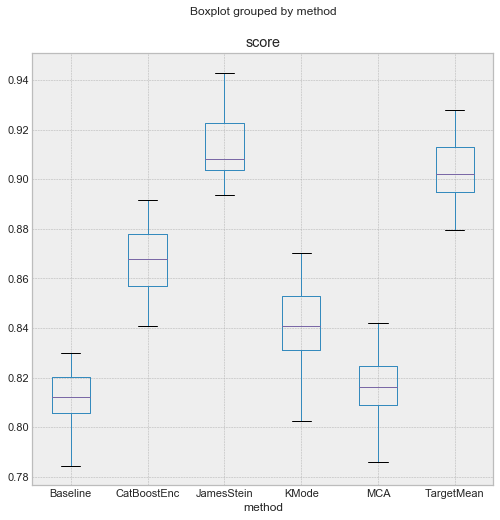

In [399]:
test = train_hist[train_hist.model!='MLR'].boxplot(column='score',by='method',figsize=(8,8))

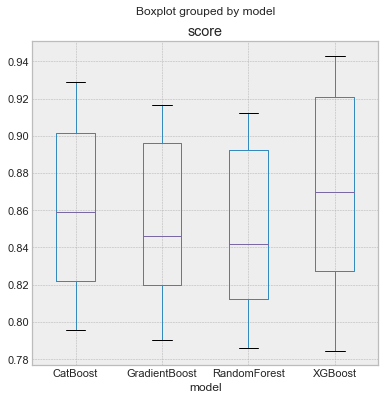

In [39]:
test = train_hist[train_hist.model!='MLR'].boxplot(column='score',by='model',figsize=(6,6))

In [443]:
import plotly.graph_objs as go

In [444]:
go.Layout

plotly.graph_objs.Layout

In [ ]:
test = train_hist[train_hist.model!='MLR'].boxplot(column='adjr2',by='method',figsize=(12,8))
plt.title('Boxplot Grouped by Method', fontdict=dict(size=16))
plt.suptitle("")
plt.xlabel("Method", fontdict=dict(size=16))
plt.ylabel("R\u00B2(Adj)", fontdict=dict(size=16))
plt.show()

CatBoost              AxesSubplot(0.1,0.679412;0.363636x0.220588)
GradientBoost    AxesSubplot(0.536364,0.679412;0.363636x0.220588)
MLR                   AxesSubplot(0.1,0.414706;0.363636x0.220588)
RandomForest     AxesSubplot(0.536364,0.414706;0.363636x0.220588)
XGBoost                   AxesSubplot(0.1,0.15;0.363636x0.220588)
dtype: object

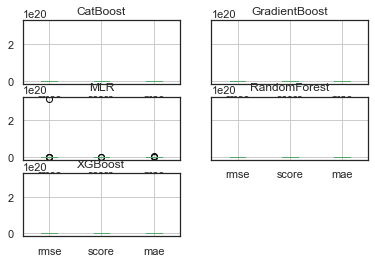

In [92]:
grouped = train_hist.groupby('model')
grouped.boxplot()

In [74]:
train_hist = train_hist.drop('iteration', axis=1)

In [382]:
train_hist[train_hist.model=='XGBoost'].groupby(['method', 'model']).score.agg({'mean': 'mean','max':'max','min':'min'})

,,mean,max,min
method,model,,,
Baseline,XGBoost,0.816034,0.829929,0.784589
CatBoostEnc,XGBoost,0.882403,0.891642,0.869438
JamesStein,XGBoost,0.931750,0.942850,0.921425
KMode,XGBoost,0.857135,0.870155,0.840403
MCA,XGBoost,0.824705,0.842247,0.808136
TargetMean,XGBoost,0.921177,0.927782,0.910989


In [395]:
train_hist[train_hist.model!='MLR'].groupby(['method']).mean()

,rmse,score,adjr2,mae
method,,,,
Baseline,135547.813448,0.811898,0.766115,81784.721618
CatBoostEnc,118162.038530,0.867583,0.841530,68629.732551
JamesStein,86901.334525,0.912764,0.899770,49976.451239
KMode,127361.617687,0.840964,0.802525,75718.095129
MCA,135102.815988,0.815404,0.769450,81354.028821
TargetMean,90951.676758,0.904086,0.889790,53428.676875


In [366]:
train_hist.groupby(['model']).mean()

,rmse,score,adjr2,mae
model,,,,
CatBoost,1.145933e+05,0.860952,0.830568,6.834845e+04
GradientBoost,1.182728e+05,0.853775,0.821396,7.065749e+04
MLR,1.169390e+24,0.633670,0.715951,2.607674e+22
RandomForest,1.188850e+05,0.848204,0.811230,7.009763e+04
XGBoost,1.109338e+05,0.872201,0.849592,6.482424e+04


In [396]:
with open('scores.tex','w') as tf:
    tf.write(train_hist[train_hist.model!='MLR'].groupby(['method']).mean().to_latex())

method
Baseline       AxesSubplot(0.125,0.125;0.775x0.755)
CatBoostEnc    AxesSubplot(0.125,0.125;0.775x0.755)
JamesStein     AxesSubplot(0.125,0.125;0.775x0.755)
KMode          AxesSubplot(0.125,0.125;0.775x0.755)
MCA            AxesSubplot(0.125,0.125;0.775x0.755)
TargetMean     AxesSubplot(0.125,0.125;0.775x0.755)
Name: score, dtype: object

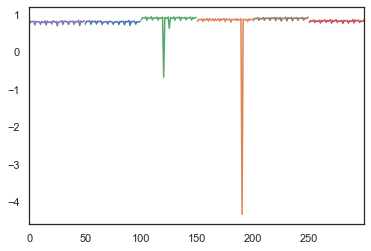

In [81]:
train_hist.groupby(['method']).score.plot()

In [40]:
train_hist = pd.read_csv('Results.csv')

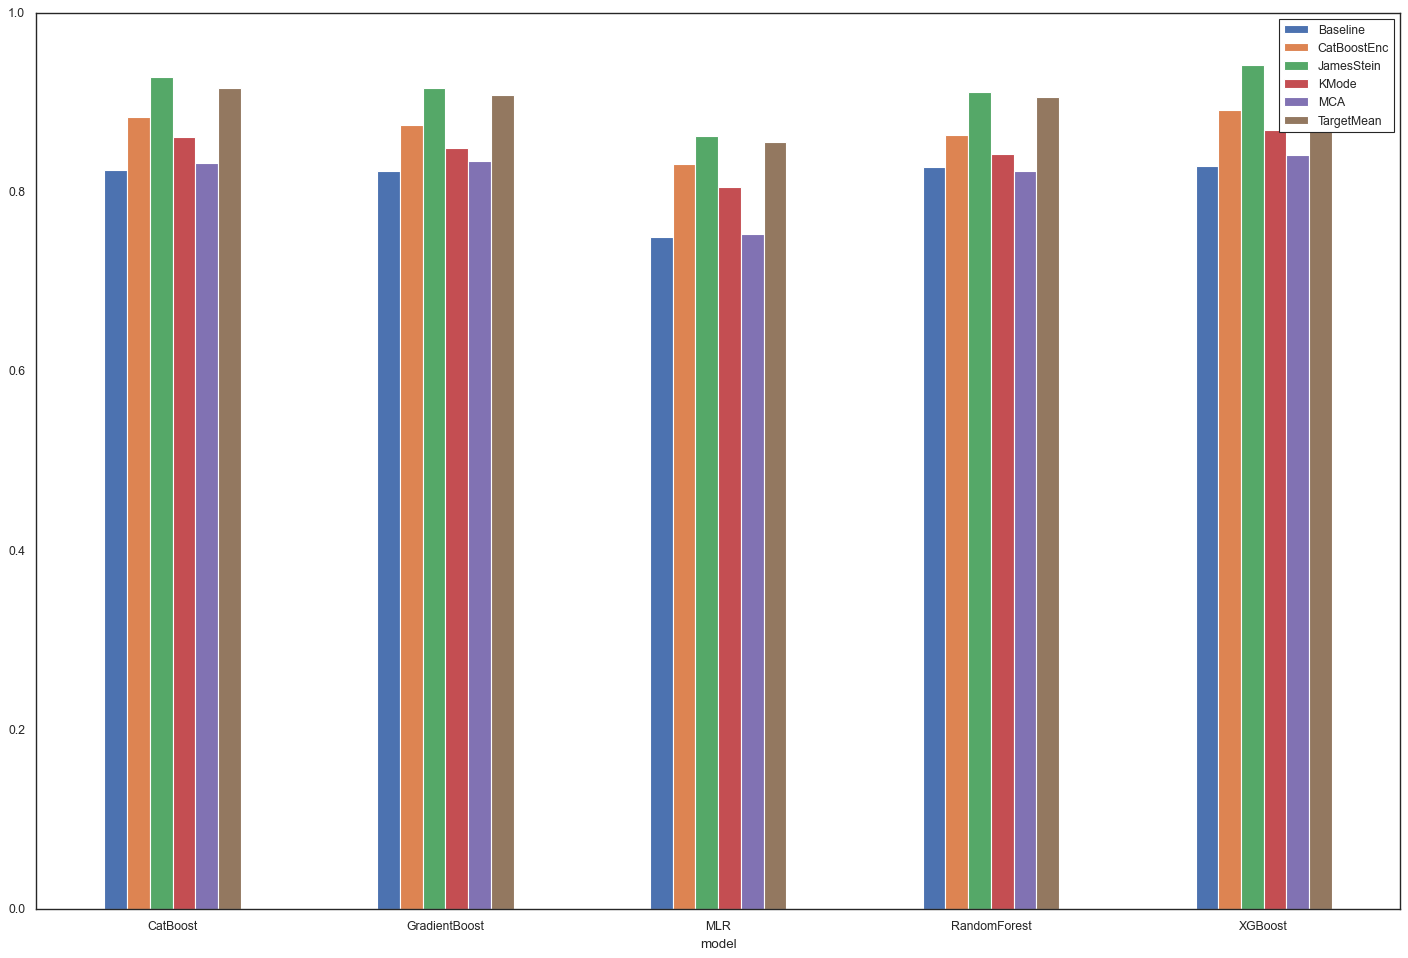

In [42]:
ax = train_hist.groupby(['method','model']).score.max().unstack(0).plot.bar(figsize=(14,14), rot=0, legend=False).legend(bbox_to_anchor=(1, 1))

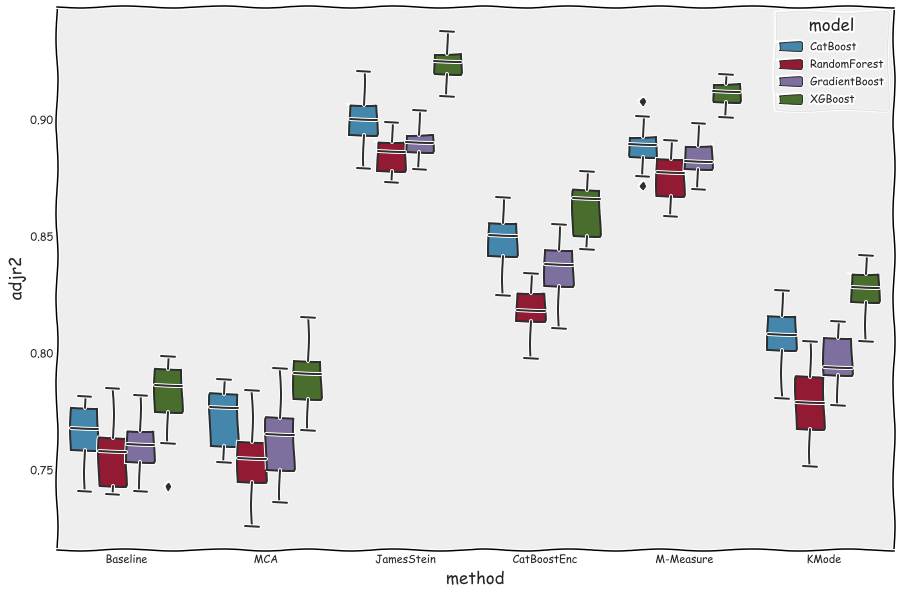

In [9]:
fig, ax = plt.subplots(figsize=(15, 10))  
sb.boxplot(x='method', y='adjr2', hue='model', data=train_hist[train_hist.model!='MLR'], ax=ax)  
plt.show()  

Statistic=0.967, p-value=0.03688931092619895935058593750000000000000000000000


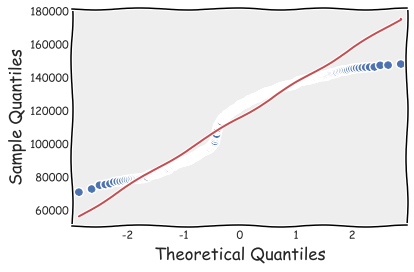

In [185]:
stat, p = shapiro(train_hist[(train_hist.model!='MLR') & (train_hist.method=='JamesStein')].rmse)
print('Statistic=%.3f, p-value=%.50f' % (stat, p))

qqplot(train_hist[(train_hist.model!='MLR')].rmse, line='s')
plt.show()

In [54]:
# Test for normality of distribution of mean absolute errors by each encoding method
norms = pd.DataFrame()

for method in train_hist.method.unique():
    stat, p = shapiro(train_hist[(train_hist.model!='MLR') & (train_hist.method==method)].mae)
    norms.loc[len(norms)+1, 'Method'] = method
    norms.loc[len(norms), 'Statistic'] = stat
    norms.loc[len(norms), 'p-value'] = p
    print(method, 'Statistic=%.3f, p-value=%.50f' % (stat, p))

Baseline Statistic=0.986, p-value=0.53283399343490600585937500000000000000000000000000
MCA Statistic=0.975, p-value=0.11478818207979202270507812500000000000000000000000
JamesStein Statistic=0.955, p-value=0.00716064125299453735351562500000000000000000000000
CatBoostEnc Statistic=0.984, p-value=0.44061091542243957519531250000000000000000000000000
M-Measure Statistic=0.952, p-value=0.00445182714611291885375976562500000000000000000000
KMode Statistic=0.990, p-value=0.78963804244995117187500000000000000000000000000000


In [484]:
# Test for normality of distribution of Root Mean Squared Error of all tests
stats.shapiro(train_hist[(train_hist.model!='MLR')].rmse)

(0.9107303619384766, 3.3721768646644825e-16)

In [509]:
# Exporting to LaTeX
with open('shapiro.tex','w') as tf:
    tf.write(norms.to_latex())

In [493]:
# Perform ANOVA of RMSE for each of the encoding methods

mod = ols('rmse ~ method', data=train_hist[train_hist.model!='MLR']).fit()
aov_table = sm.stats.anova_lm(mod, type=2, )
print(aov_table)

             df        sum_sq       mean_sq           F         PR(>F)
method      5.0  1.883438e+11  3.766876e+10  936.127982  5.595159e-243
Residual  474.0  1.907324e+10  4.023890e+07         NaN            NaN


In [ ]:
# Exporting to LaTeX
with open('anova.tex','w') as tf:
    tf.write(aov_table.to_latex())

In [505]:
JamesSteindf = train_hist[(train_hist.model!='MLR') & (train_hist.method=='JamesStein')].mae
Baselinedf = train_hist[(train_hist.model!='MLR') & (train_hist.method=='Baseline')].mae
TargetMeandf = train_hist[(train_hist.model!='MLR') & (train_hist.method=='M-Measure')].mae
CatBoostEncdf = train_hist[(train_hist.model!='MLR') & (train_hist.method=='CatBoostEnc')].mae
MCAdf = train_hist[(train_hist.model!='MLR') & (train_hist.method=='MCA')].mae
kmodedf = train_hist[(train_hist.model!='MLR') & (train_hist.method=='KMode')].mae

Levene Statistic=5.700, p-value=0.00004
Kruskal Statistic=423.975, p-value=0.00000


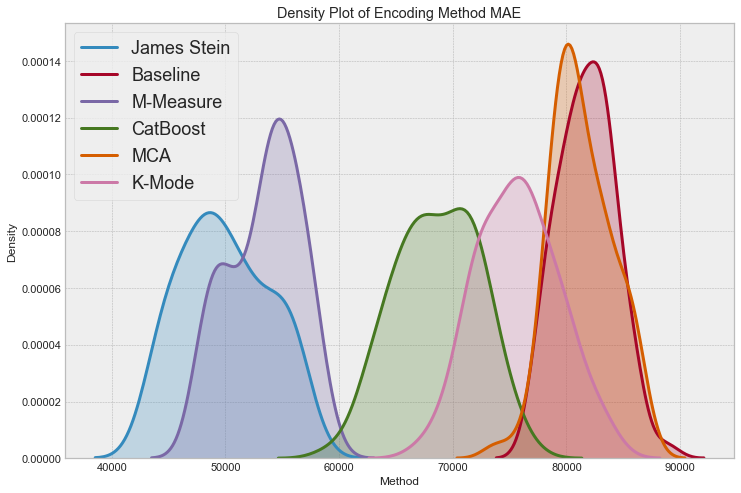

In [507]:
# Non-parametric ANOVA
plt.figure(figsize=(12, 8))
stat, p = stats.levene(JamesSteindf, Baselinedf, TargetMeandf, CatBoostEncdf, MCAdf, kmodedf)
print('Levene Statistic=%.3f, p-value=%.5f' % (stat, p))
stat, p = stats.kruskal(JamesSteindf, Baselinedf, TargetMeandf, CatBoostEncdf, MCAdf, kmodedf)
print("Kruskal Statistic=%.3f, p-value=%.5f" % (stat, p))

sb.distplot(JamesSteindf, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},
                 label = 'James Stein', )
sb.distplot(Baselinedf, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},
                 label = 'Baseline')
sb.distplot(TargetMeandf, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},
                 label = 'M-Measure')
sb.distplot(CatBoostEncdf, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},
                 label = 'CatBoost')
sb.distplot(MCAdf, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},
                 label = 'MCA')
sb.distplot(kmodedf, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},
                 label = 'K-Mode')
    
# Plot formatting
plt.legend(prop={'size': 18})
plt.title('Density Plot of Encoding Method MAE')
plt.xlabel('Method')
plt.ylabel('Density')
plt.show()

In [302]:
# Exporting to LaTeX
with open('anova.tex','w') as tf:
    tf.write(aov_table.to_latex())

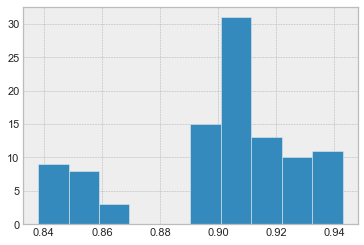

In [43]:
train_hist[(train_hist.method=='JamesStein')].score.hist()

In [428]:
iter_data = prep_data.copy()
mca = prince.MCA(n_components=1000, n_iter=2, copy=True, check_input=True)
iter_data[target_cols] = iter_data[target_cols].fillna('unknown')
mca = mca.fit(iter_data[target_cols])

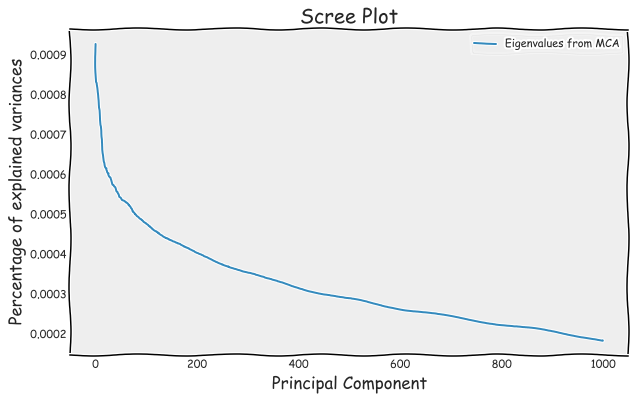

In [511]:
components = np.arange(len(mca.explained_inertia_))

fig = plt.figure(figsize=(10,6))
plt.plot(components, mca.explained_inertia_, linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Percentage of explained variances')
leg = plt.legend(['Eigenvalues from MCA'], loc='best', borderpad=0.3, 
                 shadow=False, markerscale=0.4)
leg.get_frame().set_alpha(0.4)

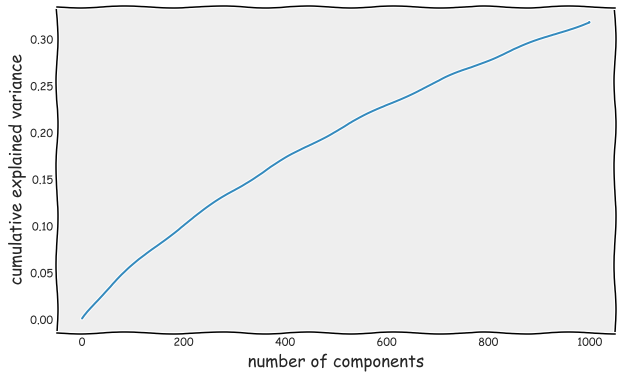

In [512]:
fig = plt.figure(figsize=(10,6))
plt.plot(np.cumsum(mca.explained_inertia_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [ ]:
mca.total_inertia_

In [ ]:
ax = mca.plot_coordinates(
     X=iter_data[target_cols],
     ax=None,
     figsize=(6, 6),
     show_row_points=True,
     row_points_size=10,
     show_row_labels=False,
     show_column_points=True,
     column_points_size=30,
     show_column_labels=False,
     legend_n_cols=1
)

In [ ]:
iter_data = prep_data.copy()
target_cols = comma_cols + ['ZipCode', 'Area']

In [ ]:
clusters = iter_data[target_cols]

In [ ]:
clusters = pd.DataFrame()
for col in target_cols:
    iter_data[col].fillna('Unknown', inplace=True)
    dummies = iter_data[col].astype('str').str.get_dummies(sep=',')
    clusters = pd.concat([clusters, dummies], axis=1)

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

#sample_silhouette_values = []
#Sum_of_squared_distances = []
K = [50]
#K = range(4,20)
for k in K:

    km = KModes(n_clusters=k)
    clustered = km.fit_predict(clusters)
    silhouette_avg = silhouette_score(clusters, clustered)
    Sum_of_squared_distances.append(silhouette_avg)
    print("For n_clusters =", k,
          "The average silhouette_score is :", silhouette_avg)
    #sample_silhouette_values.append(silhouette_samples(clusters, clustered))

In [75]:
iter_data

,ZipCode,YearBuilt,SqFt,Style,Stories,TotalRooms,Bedrooms,FullBaths,Garage,Fireplace,...,MedianSalePrice,MedianSalePriceMom,MedianSalePriceYoy,NewListings,NewListingsMom,NewListingsYoy,Condo/Townhouse,Single Family Home,Attached,Detached
0,95403,2006.0,1919,6.471895e+05,663858.604201,8.0,4.0,3.0,2.0,6.652535e+05,...,617000.0,-0.015,-0.030,501,-0.017,-0.112,0,1,1,0
1,95492,1987.0,980,6.153109e+05,663858.604201,4.0,2.0,2.0,2.0,6.431050e+05,...,617000.0,-0.015,-0.030,501,-0.017,-0.112,1,0,1,0
2,95409,1980.0,1382,6.153109e+05,663858.604201,5.0,2.0,1.0,2.0,6.187571e+05,...,608000.0,-0.001,-0.061,549,0.145,0.297,1,0,1,0
3,95409,1987.0,1188,4.264182e+05,663858.604201,4.0,2.0,2.0,2.0,6.431050e+05,...,602000.0,-0.022,-0.042,514,-0.056,-0.040,1,0,1,0
4,94928,1974.0,2226,7.943406e+05,663858.604201,6.0,5.0,3.0,2.0,6.187571e+05,...,626000.0,-0.001,0.086,520,-0.038,0.115,0,1,0,1
5,95409,1964.0,1155,6.535000e+05,641413.034055,5.0,2.0,2.0,1.0,6.552768e+05,...,615000.0,-0.018,0.018,545,0.048,0.260,0,1,0,1
6,95401,1984.0,998,7.943406e+05,663858.604201,5.0,2.0,1.0,1.0,5.718491e+05,...,615000.0,-0.018,0.018,545,0.048,0.260,1,0,1,0
7,95448,1953.0,1662,6.153109e+05,641413.034055,6.0,3.0,2.0,2.0,7.500000e+05,...,642000.0,0.004,0.103,554,0.202,0.190,0,1,0,1
8,95403,1989.0,799,7.943406e+05,641413.034055,4.0,2.0,1.0,1.0,5.718491e+05,...,577000.0,-0.008,0.021,466,-0.065,-0.058,1,0,1,0
9,95407,1949.0,1152,6.028243e+05,641413.034055,4.0,2.0,1.0,1.0,6.187571e+05,...,577000.0,-0.008,0.021,466,-0.065,-0.058,0,1,0,1


In [83]:
iter_data = prep_data.copy()

for col in target_cols:
    encoder = JamesSteinEncoder(return_df=False, model='independent')
    iter_data[col] = encoder.fit_transform(iter_data[col], iter_data.SoldPrice)
    
dependant = iter_data['SoldPrice']
dependant = np.log1p(dependant)

independant = iter_data.drop('SoldPrice', axis=1)
col_names = independant.columns

sc = StandardScaler()
independant_s = sc.fit_transform(independant)

train_features, test_features, train_labels, test_labels = train_test_split(independant_s, 
                                                                                dependant, 
                                                                                test_size = 0.2)

# Import the model we are using
from sklearn.linear_model import LinearRegression

# Instantiate model with 1000 decision trees
lr = LinearRegression()

# Train the model on training data
lr.fit(train_features, train_labels)

# Use the forest's predict method on the test data
predictions = lr.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
print('Mean Squared Error:', mean_squared_error(test_labels, predictions))
print(lr.score(test_features, test_labels))

Mean Absolute Error: 0.11 degrees.
Mean Squared Error: 0.023456186070813328
0.8378324908006112


In [45]:
train_hist[train_hist.model=='XGBoost'].adjr2.max()

0.937651

In [ ]:
sample_silhouette_values

In [ ]:
max(km.cluster_centroids_[0])

In [ ]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

# Exploring Feature Importance

In [ ]:
from sklearn.linear_model import Lasso

In [ ]:
cleaned_data = cleaned_data.reset_index(drop=True)
comma_cols = comma_cols + ['ZipCode', 'Area']

for col in comma_cols:
    cleaned_data[col].fillna('Unknown', inplace=True)
    smooth_target_clust(cleaned_data, col, 'SoldPrice', 10)

In [ ]:
k_cleaned_data.reset_index(drop=True, inplace=True)
full_cols = comma_cols + ['ZipCode', 'Area']
k_cols_dict = {}


for col in full_cols:
    k_cleaned_data[col].fillna('Unknown', inplace=True)
    clus_dist, new_cols = kmodes_cats(k_cleaned_data[col], 
                                      k_cleaned_data[col].astype('str').str.get_dummies(sep=','),
                                      5, col)
    k_cleaned_data = k_cleaned_data.drop(col, axis=1)
    k_cleaned_data.reset_index(drop=True, inplace=True)
    k_cleaned_data = k_cleaned_data.join(new_cols)
    k_cols_dict.update({col: clus_dist})

In [ ]:
k_cleaned_data.drop('HOAPaid', axis=1, inplace=True)
k_cleaned_data.reset_index(drop=True, inplace=True)
k_cleaned_data.HOAAmount.fillna(0, inplace=True)
null_counts = len(k_cleaned_data) - k_cleaned_data.count()
null_counts[null_counts > 0]

In [ ]:
null_counts = len(k_cleaned_data) - k_cleaned_data.count()
null_counts[null_counts > 0]

In [ ]:
for column in null_counts[null_counts > 0].index:
    k_cleaned_data[column].fillna(k_cleaned_data[column].median(), inplace=True)

In [ ]:
backup = k_cleaned_data.copy()

In [ ]:
k_cleaned_data = backup.copy()

In [ ]:
k_propTypeClus = k_cleaned_data.PropertyType.str.get_dummies()
propTypeClus.reset_index(drop=True, inplace=True)
k_cleaned_data.drop('PropertyType', axis=1, inplace=True)
k_cleaned_data.reset_index(drop=True, inplace=True)
k_cleaned_data = k_cleaned_data.join(propTypeClus)

In [ ]:
propTypeClus.reset_index(drop=True, inplace=True)

In [ ]:
k_cleaned_data = k_cleaned_data.join(propTypeClus)

In [ ]:
k_AttachDetachHomeClus = k_cleaned_data.AttachDetachHome.str.get_dummies()
k_AttachDetachHomeClus.reset_index(drop=True, inplace=True)
k_cleaned_data.drop('AttachDetachHome', axis=1, inplace=True)
k_cleaned_data.reset_index(drop=True, inplace=True)
k_cleaned_data = k_cleaned_data.join(k_AttachDetachHomeClus)

In [ ]:
k_prep_data = k_cleaned_data.drop(['ListingPrice', 'SoldDate', 'ConstructCondition'], axis=1)

In [ ]:
k_prep_data

In [ ]:
k_dependant = k_prep_data['SoldPrice']
k_dependant = np.log1p(k_dependant)

k_independant = k_prep_data.drop('SoldPrice', axis=1)
k_col_names = k_independant.columns

ksc = StandardScaler()
k_independant_s = ksc.fit_transform(k_independant)

k_train_features, k_test_features, k_train_labels, k_test_labels = train_test_split(k_independant_s,
                                                                                    k_dependant, 
                                                                                    test_size = 0.2)

# Instantiate model with 500 decision trees
k_rf = RandomForestRegressor(n_estimators=1000, n_jobs = -1,
                                  max_features = "auto",
                                  max_leaf_nodes = 200)

# Train the model on training data
k_rf.fit(k_train_features, k_train_labels)

# Predict on the test dataset
k_predictions = k_rf.predict(k_test_features)
k_errors = abs(np.expm1(k_test_labels) - np.expm1(k_predictions))
print('RF Mean Absolute Error:', round(np.mean(k_errors), 2))
k_rmse = np.sqrt(mean_squared_error(np.expm1(k_test_labels), np.expm1(k_predictions)))
print("RF RMSE: %f" % (k_rmse))
print("RF Accuracy:", k_rf.score(k_test_features, k_test_labels))




# Instantiate model with 500 decision trees
k_gbr = GradientBoostingRegressor(n_estimators=100,
                                  max_features = "auto",
                                  max_leaf_nodes = 200)

# Train the model on training data
k_gbr.fit(k_train_features, k_train_labels)

# Predict on the test dataset
k_predictions = k_gbr.predict(k_test_features)
k_errors = abs(np.expm1(k_test_labels) - np.expm1(k_predictions))
print('GBR Mean Absolute Error:', round(np.mean(k_errors), 2), 'degrees.')
k_rmse = np.sqrt(mean_squared_error(np.expm1(k_test_labels), np.expm1(k_predictions)))
print("GBR RMSE: %f" % (k_rmse))
print("GBR Accuracy:", k_gbr.score(k_test_features, k_test_labels))



k_xgboost = xgb.XGBRegressor(learning_rate=0.01,n_estimators=3460,
                             objective='reg:squarederror',
                             max_depth=6, min_child_weight=0,
                             gamma=0, subsample=0.7,
                             colsample_bytree=0.7,
                             nthread=-1,
                             scale_pos_weight=1, seed=27,
                             reg_alpha=0.00006)

k_xgboost.fit(k_train_features, k_train_labels)
k_predictions = k_xgboost.predict(k_test_features)
k_errors = abs(np.expm1(k_test_labels) - np.expm1(k_predictions))
print('XGBoost Mean Absolute Error:', round(np.mean(k_errors), 2))
k_rmse = np.sqrt(mean_squared_error(np.expm1(k_test_labels), np.expm1(k_predictions)))
print("XGBoost RMSE: %f" % (k_rmse))
print("XGBoost Accuracy:", k_xgboost.score(k_test_features, k_test_labels))

In [ ]:
null_counts = len(k_cleaned_data) - k_cleaned_data.count()

In [ ]:
null_counts[null_counts > 0].index

In [ ]:
for column in null_counts[null_counts > 0].index:
    k_cleaned_data[column] = k_cleaned_data[column].fillna(k_cleaned_data[column].median())

In [ ]:
k_train_features[np.isnan(k_train_features)]

In [ ]:
cleaned_data.drop('HOAPaid', axis=1, inplace=True)
cleaned_data.HOAAmount.fillna(0, inplace=True)
null_counts = len(cleaned_data) - cleaned_data.count()
null_counts[null_counts > 0]

In [ ]:
for column in null_counts[null_counts > 0].index:
    cleaned_data[column].fillna(cleaned_data[column].median(), inplace=True)

In [ ]:
smooth_target_clust(cleaned_data, 'ZipCode', 'SoldPrice', 10)

In [ ]:
smooth_target_clust(cleaned_data, 'Area', 'SoldPrice', 10)

In [ ]:
propTypeClus = cleaned_data.PropertyType.str.get_dummies()
cleaned_data.drop('PropertyType', axis=1, inplace=True)
cleaned_data = pd.concat([cleaned_data, propTypeClus], axis=1)

In [ ]:
AttachDetachHomeClus = cleaned_data.AttachDetachHome.str.get_dummies()
cleaned_data.drop('AttachDetachHome', axis=1, inplace=True)
cleaned_data = pd.concat([cleaned_data, AttachDetachHomeClus], axis=1)

In [ ]:
cleaned_data.ConstructCondition.value_counts()

In [ ]:
temp_df = cleaned_data.copy()
temp_df['error'] = temp_df.SoldPrice - temp_df.ListingPrice

weekly_medians = temp_df.groupby([pd.Grouper(key='SoldDate', freq='w')]).SoldPrice.agg({'weeklyMed': 'median'})
weekly_medians = weekly_medians.reset_index().sort_values('SoldDate')

weekly_errors = temp_df.groupby([pd.Grouper(key='SoldDate', freq='w')]).error.agg({'weeklyErr': 'mean'})
weekly_errors = weekly_errors.reset_index().sort_values('SoldDate')

In [ ]:
test_data = cleaned_data[cleaned_data.SoldDate > weekly_medians.SoldDate[9]]

In [ ]:
def prior_stats(rec_date):
    reg = linear_model.LinearRegression()
    past_weeks = weekly_medians[(weekly_medians.SoldDate > (rec_date - pd.DateOffset(weeks=8))) & 
                  (weekly_medians.SoldDate < rec_date)]
    date_ord = pd.to_datetime(past_weeks.SoldDate).map(datetime.datetime.toordinal)
    reg.fit(date_ord.values.reshape(-1, 1), past_weeks.weeklyMed.values)
    med_coef = reg.coef_[0]
    med_int  = reg.intercept_
    med_prev = past_weeks.iloc[-1].weeklyMed
    
    reg = linear_model.LinearRegression()
    past_weeks = weekly_errors[(weekly_errors.SoldDate > (rec_date - pd.DateOffset(weeks=8))) & 
                  (weekly_errors.SoldDate < rec_date)]
    date_ord = pd.to_datetime(past_weeks.SoldDate).map(datetime.datetime.toordinal)
    reg.fit(date_ord.values.reshape(-1, 1), past_weeks.weeklyErr.values)
    err_coef = reg.coef_[0]
    err_int  = reg.intercept_
    err_prev = past_weeks.iloc[-1].weeklyErr
    
    return med_coef, med_int, med_prev, err_coef, err_int, err_prev

In [ ]:
new_cols = test_data.SoldDate.apply(prior_stats)

In [ ]:
new_cols = pd.DataFrame(new_cols.tolist(), columns=['med_coef', 'med_int', 'med_prev', 'err_coef', 'err_int', 'err_prev'])

In [ ]:
new_cols = new_cols.reset_index()
test_data = test_data.reset_index()

In [ ]:
test_data = pd.concat([test_data, new_cols], axis=1)

In [ ]:
prep_data = test_data.drop(['ListingPrice', 'SoldDate', 'ConstructCondition', 'index'], axis=1)

In [ ]:
prep_data = cleaned_data.drop(['ListingPrice', 'SoldDate', 'ConstructCondition'], axis=1)

In [ ]:
cleaned_data.SoldPrice

In [ ]:
correlations = cleaned_data.corr()

f, ax = plt.subplots(figsize =(26, 26)) 
ax = sb.heatmap(
    correlations, 
    ax = ax,
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [ ]:
prep_data.to_csv('prep_data.csv')

In [ ]:
dependant = prep_data['SoldPrice']
dependant = np.log1p(dependant)

independant = prep_data.drop('SoldPrice', axis=1)
col_names = independant.columns

In [ ]:
dependant.hist(bins=40)
qqplot(dependant, line='s')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
independant_s = sc.fit_transform(independant)

train_features, test_features, train_labels, test_labels = train_test_split(independant_s, 
                                                                            dependant, 
                                                                            test_size = 0.2)

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Instantiate model with 500 decision trees
rf = RandomForestRegressor(n_estimators=1000, n_jobs = -1,
                                  max_features = "auto",
                                  max_leaf_nodes = 200)

# Train the model on training data
rf.fit(train_features, train_labels)

# Predict on the test dataset
predictions = rf.predict(test_features)
errors = abs(np.expm1(test_labels) - np.expm1(predictions))
print('Mean Absolute Error:', round(np.mean(errors), 2))
rmse = np.sqrt(mean_squared_error(np.expm1(test_labels), np.expm1(predictions)))
print("RMSE: %f" % (rmse))
print("Accuracy:", rf.score(test_features, test_labels))

In [ ]:
list(np.c_[np.expm1(test_labels), np.expm1(predictions)])

In [ ]:
# Import the model we are using
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Instantiate model with 500 decision trees
gbr = GradientBoostingRegressor(n_estimators=100,
                                  max_features = "auto",
                                  max_leaf_nodes = 200)

# Train the model on training data
gbr.fit(train_features, train_labels)

# Predict on the test dataset
predictions = gbr.predict(test_features)
errors = abs(np.expm1(test_labels) - np.expm1(predictions))
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
rmse = np.sqrt(mean_squared_error(np.expm1(test_labels), np.expm1(predictions)))
print("RMSE: %f" % (rmse))
print("Accuracy:", gbr.score(test_features, test_labels))

In [ ]:
import xgboost as xgb

xgboost = xgb.XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=6, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

xgboost.fit(train_features, train_labels)
predictions = xgboost.predict(test_features)
errors = abs(np.expm1(test_labels) - np.expm1(predictions))
print('Mean Absolute Error:', round(np.mean(errors), 2))
rmse = np.sqrt(mean_squared_error(np.expm1(test_labels), np.expm1(predictions)))
print("RMSE: %f" % (rmse))
print("Accuracy:", xgboost.score(test_features, test_labels))

In [85]:
importance = pd.DataFrame(zip(col_names, xgboost.feature_importances_))
importance = importance.sort_values(by=1, ascending=False)
#print(importance[-26:])
importance

,0,1
67,Single Family Home,0.404346
66,Condo/Townhouse,0.283527
2,SqFt,0.068870
33,Kitchen,0.041367
18,LotSize,0.024193
11,Area,0.022202
69,Detached,0.015298
68,Attached,0.011886
7,FullBaths,0.008744
20,SewerSeptic,0.007210


In [297]:
with open('importances.tex','w') as tf:
    tf.write(importance.head(10).to_latex())

In [86]:
importance = importance.rename(columns={0:'Feature', 1:'Importance'})

In [87]:
importance

,Feature,Importance
67,Single Family Home,0.404346
66,Condo/Townhouse,0.283527
2,SqFt,0.068870
33,Kitchen,0.041367
18,LotSize,0.024193
11,Area,0.022202
69,Detached,0.015298
68,Attached,0.011886
7,FullBaths,0.008744
20,SewerSeptic,0.007210


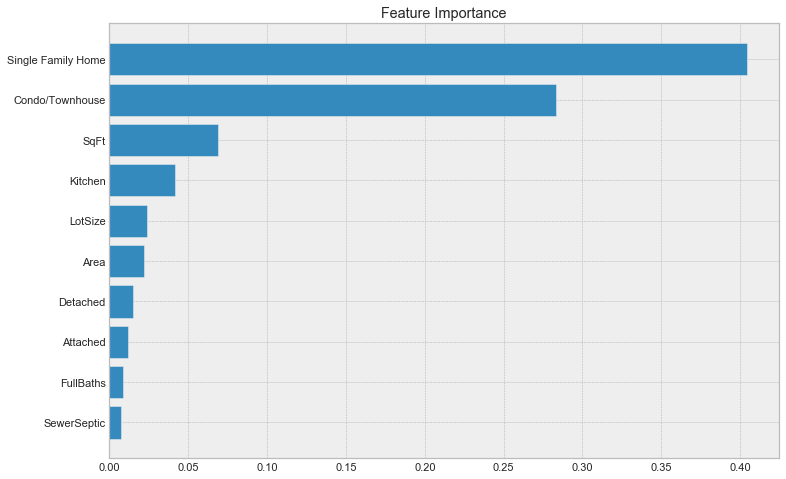

In [90]:
plt.figure(figsize=(12,8))

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.barh(range(10), importance.head(10).Importance.sort_values())

# Add feature names as x-axis labels
plt.yticks(range(10), importance.head(10).sort_values(by='Importance').Feature)

# Show plot
plt.show()

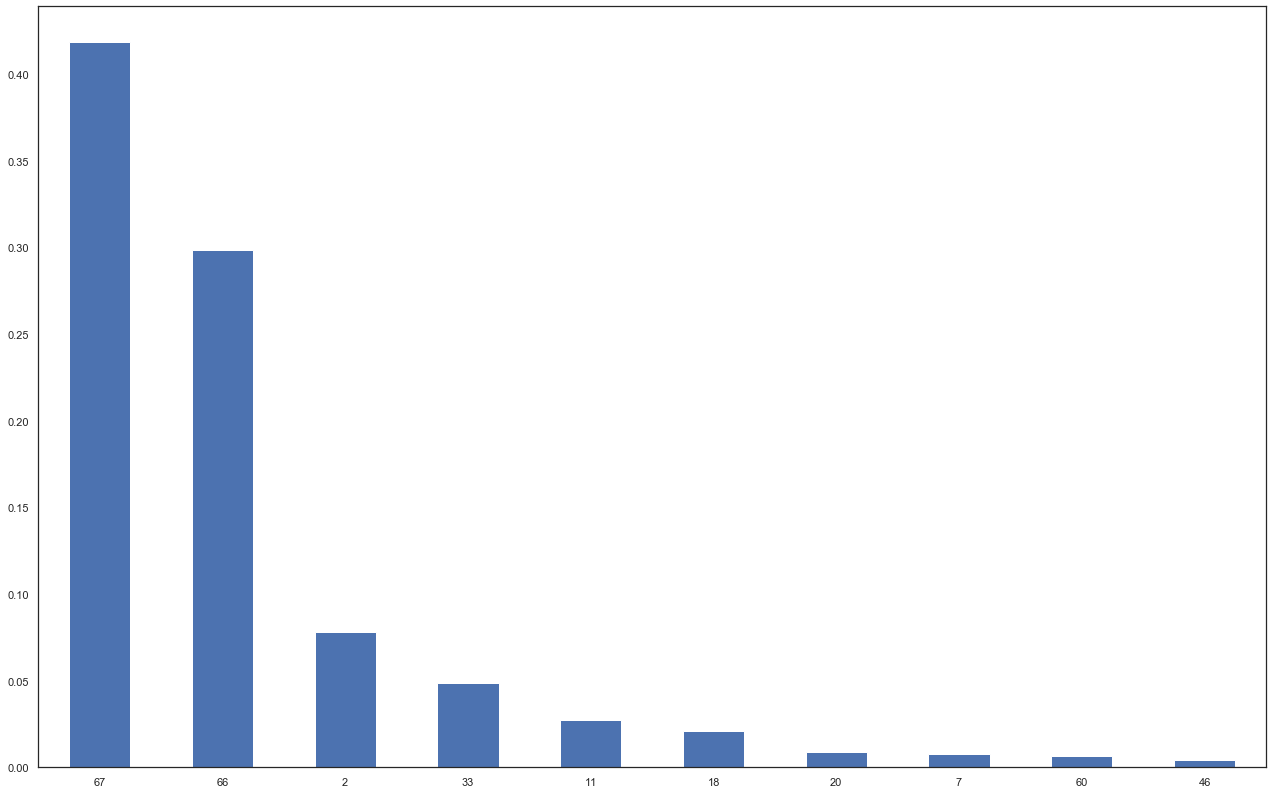

In [307]:
importance[['Feature', 'Importance']].head(10).plot.bar(figsize=(22,14), rot=0, legend=False)

In [ ]:
from sklearn import linear_model

regr = linear_model.Ridge(alpha=.05)
regr.fit(train_features, train_labels)
predictions = regr.predict(test_features)
errors = abs(np.expm1(test_labels) - np.expm1(predictions))
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
#rmse = np.sqrt(mean_squared_error(np.expm1(test_labels), np.expm1(predictions)))
#print("RMSE: %f" % (rmse))
print("Accuracy:", regr.score(test_features, test_labels))

In [ ]:
#latest = datetime.datetime(2018, 10, 30)

preFire = cleaned_data[cleaned_data.SoldDate < fires_start]
postFire = cleaned_data[(cleaned_data.SoldDate > fires_end)]

In [ ]:
pref_data = preFire.drop(['ListingPrice', 'SoldDate', 'ConstructCondition'], axis=1)
post_data = postFire.drop(['ListingPrice', 'SoldDate', 'ConstructCondition'], axis=1)

In [ ]:
pref_dependant = np.log1p(pref_data['SoldPrice'])
post_dependant = np.log1p(post_data['SoldPrice'])

pref_independant = pref_data.drop('SoldPrice', axis=1)
post_independant = post_data.drop('SoldPrice', axis=1)
#col_names = independant.columns

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

pref_independant = sc.fit_transform(pref_independant)

pref_train_features, pref_test_features, pref_train_labels, pref_test_labels = train_test_split(pref_independant, 
                                                                                                pref_dependant, 
                                                                                                test_size = 0.2)

post_independant = sc.fit_transform(post_independant)

post_train_features, post_test_features, post_train_labels, post_test_labels = train_test_split(post_independant, 
                                                                                                post_dependant, 
                                                                                                test_size = 0.2)

In [ ]:
import xgboost as xgb

pref_xgboost = xgb.XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=6, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=42,
                                     reg_alpha=0.00006)

pref_xgboost.fit(pref_train_features, pref_train_labels)
pref_predictions = pref_xgboost.predict(pref_test_features)
pref_errors = abs(np.expm1(pref_test_labels) - np.expm1(pref_predictions))
print('Pre Fire Mean Absolute Error:', round(np.mean(pref_errors), 2))
pref_rmse = np.sqrt(mean_squared_error(np.expm1(pref_test_labels), np.expm1(pref_predictions)))
print("Pre Fire RMSE: %f" % (pref_rmse))
print("Pre Fire Accuracy:", pref_xgboost.score(pref_test_features, pref_test_labels))

In [ ]:
import xgboost as xgb

post_xgboost = xgb.XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=6, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=42,
                                     reg_alpha=0.00006)

post_xgboost.fit(post_train_features, post_train_labels)
post_predictions = post_xgboost.predict(post_test_features)
post_errors = abs(np.expm1(post_test_labels) - np.expm1(post_predictions))
print('Post Fire Mean Absolute Error:', round(np.mean(post_errors), 2))
post_rmse = np.sqrt(mean_squared_error(np.expm1(post_test_labels), np.expm1(post_predictions)))
print("Post Fire RMSE: %f" % (post_rmse))
print("Post Fire Accuracy:", post_xgboost.score(post_test_features, post_test_labels))

In [ ]:
zipCols = ['95409', '94928', '95404', '95403', '94954', '95401', '95492', '94952', 
           '95405', '95407', '95448', '94931', '95439', '95952', '95402', '94942']

importances = pd.merge(pref_importance.assign(grouper=pref_importance[0]), 
                         post_importance.assign(grouper=post_importance[0]),
                         how='left', on='grouper').drop(['0_x', '0_y'], axis=1)
importances[importances.grouper.isin(zipCols)]

In [ ]:
import matplotlib.lines as mlines
pref_importances = pref_xgboost.feature_importances_
post_importances = post_xgboost.feature_importances_

left_label = [str(c) + ', '+ str(round(y)) for c, y in zip(col_names, pref_importances)]
right_label = [str(c) + ', '+ str(round(y)) for c, y in zip(col_names, post_importances)]
klass = ['red' if (y1-y2) < 0 else 'green' for y1, y2 in zip(pref_importances, post_importances)]

def newline(p1, p2, color='black'):
    ax = plt.gca()
    l = mlines.Line2D([p1[0],p2[0]], [p1[1],p2[1]], color='red' if p1[1]-p2[1] > 0 else 'green', marker='o', markersize=6)
    ax.add_line(l)
    return l

fig, ax = plt.subplots(1,1,figsize=(8,18), dpi= 80)

ax.vlines(x=1, ymin=0.03, ymax=0.3, color='black', alpha=0.7, linewidth=1, linestyles='dotted')
ax.vlines(x=3, ymin=0.03, ymax=0.3, color='black', alpha=0.7, linewidth=1, linestyles='dotted')

pref_importance = pd.DataFrame(zip(col_names, pref_xgboost.feature_importances_))
post_importance = pd.DataFrame(zip(col_names, post_xgboost.feature_importances_))
importances = pd.merge(pref_importance.assign(grouper=pref_importance[0]), 
                         post_importance.assign(grouper=post_importance[0]),
                         how='left', on='grouper').drop(['0_x', '0_y'], axis=1)
importances = importances.sort_values(by='1_x', ascending=False)[:6]

ax.scatter(y=importances['1_x'], x=np.repeat(1, importances.shape[0]), s=10, color='black', alpha=0.7)
ax.scatter(y=importances['1_y'], x=np.repeat(3, importances.shape[0]), s=10, color='black', alpha=0.7)


for p1, p2, c in zip(importances['1_x'], importances['1_y'], importances.grouper):
    newline([1,p1], [3,p2])
    ax.text(1-0.05, p1, c + ', ' + str(p1), horizontalalignment='right', 
            verticalalignment='center', fontdict={'size':14})
    ax.text(3+0.05, p2, c + ', ' + str(p2), horizontalalignment='left', 
            verticalalignment='center', fontdict={'size':14})
    
ax.text(1-0.05, 0.3, 'BEFORE', horizontalalignment='right', verticalalignment='center', fontdict={'size':18, 'weight':700})
ax.text(3+0.05, 0.3, 'AFTER', horizontalalignment='left', verticalalignment='center', fontdict={'size':18, 'weight':700})

ax.set_title("Slopechart: Comparing Feature Importances Before and After Fires", fontdict={'size':22})
ax.set_xticks([1,3])
ax.set_xticklabels(["Before", "After"])
plt.yticks(np.arange(0.03, 0.3, 0.05), fontsize=12)

In [ ]:
import matplotlib.lines as mlines
pref_importances = pref_xgboost.feature_importances_
post_importances = post_xgboost.feature_importances_

zipCols = ['95409', '94928', '95404', '95403', '94954', '95401', '95492', '94952', 
           '95405', '95407', '95448', '94931', '95439', '95952', '95402', '94942']

left_label = [str(c) + ', '+ str(round(y)) for c, y in zip(col_names, pref_importances)]
right_label = [str(c) + ', '+ str(round(y)) for c, y in zip(col_names, post_importances)]
klass = ['red' if (y1-y2) < 0 else 'green' for y1, y2 in zip(pref_importances, post_importances)]

def newline(p1, p2, color='black'):
    ax = plt.gca()
    l = mlines.Line2D([p1[0],p2[0]], [p1[1],p2[1]], color='red' if p1[1]-p2[1] > 0 else 'green', marker='o', markersize=6)
    ax.add_line(l)
    return l

fig, ax = plt.subplots(1,1,figsize=(8,18), dpi= 80)

ax.vlines(x=1, ymin=0.0, ymax=0.02, color='black', alpha=0.7, linewidth=1, linestyles='dotted')
ax.vlines(x=3, ymin=0.0, ymax=0.02, color='black', alpha=0.7, linewidth=1, linestyles='dotted')

pref_importance = pd.DataFrame(zip(col_names, pref_xgboost.feature_importances_))
post_importance = pd.DataFrame(zip(col_names, post_xgboost.feature_importances_))
importances = pd.merge(pref_importance.assign(grouper=pref_importance[0]), 
                         post_importance.assign(grouper=post_importance[0]),
                         how='left', on='grouper').drop(['0_x', '0_y'], axis=1)
importances = importances[importances.grouper.isin(zipCols)]
importances = importances.sort_values(by='1_x', ascending=False)

ax.scatter(y=importances['1_x'], x=np.repeat(1, importances.shape[0]), s=10, color='black', alpha=0.7)
ax.scatter(y=importances['1_y'], x=np.repeat(3, importances.shape[0]), s=10, color='black', alpha=0.7)


for p1, p2, c in zip(importances['1_x'], importances['1_y'], importances.grouper):
    newline([1,p1], [3,p2])
    ax.text(1-0.05, p1, c + ', ' + str(p1), horizontalalignment='right', 
            verticalalignment='center', fontdict={'size':14})
    ax.text(3+0.05, p2, c + ', ' + str(p2), horizontalalignment='left', 
            verticalalignment='center', fontdict={'size':14})
    
ax.text(1-0.05, 0.02, 'BEFORE', horizontalalignment='right', verticalalignment='center', fontdict={'size':18, 'weight':700})
ax.text(3+0.05, 0.02, 'AFTER', horizontalalignment='left', verticalalignment='center', fontdict={'size':18, 'weight':700})

ax.set_title("Slopechart: Comparing Feature Importances Before and After Fires", fontdict={'size':22})
ax.set_xticks([1,3])
ax.set_xticklabels(["Before", "After"])
plt.yticks(np.arange(0.0, 0.02, 0.0025), fontsize=12)

In [ ]:
from sklearn import linear_model

pref_regr = linear_model.Ridge(alpha=.05)
pref_regr.fit(pref_train_features, pref_train_labels)
pref_predictions = pref_regr.predict(pref_test_features)
errors = abs(np.expm1(pref_test_labels) - np.expm1(pref_predictions))
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
#rmse = np.sqrt(mean_squared_error(np.expm1(test_labels), np.expm1(predictions)))
#print("RMSE: %f" % (rmse))
print("Accuracy:", regr.score(pref_test_features, pref_test_labels))

In [ ]:
from sklearn import linear_model

post_regr = linear_model.Ridge(alpha=.05)
post_regr.fit(post_train_features, post_train_labels)
post_predictions = post_regr.predict(post_test_features)
errors = abs(np.expm1(post_test_labels) - np.expm1(post_predictions))
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
#rmse = np.sqrt(mean_squared_error(np.expm1(test_labels), np.expm1(predictions)))
#print("RMSE: %f" % (rmse))
print("Accuracy:", regr.score(post_test_features, post_test_labels))

In [ ]:
import matplotlib.lines as mlines
pref_importances = pref_regr.coef_
post_importances = post_regr.coef_

zipCols = ['95409', '94928', '95404', '95403', '94954', '95401', '95492', '94952', 
           '95405', '95407', '95448', '94931', '95439', '95952', '95402', '94942']

left_label = [str(c) + ', '+ str(round(y)) for c, y in zip(col_names, pref_importances)]
right_label = [str(c) + ', '+ str(round(y)) for c, y in zip(col_names, post_importances)]
klass = ['red' if (y1-y2) < 0 else 'green' for y1, y2 in zip(pref_importances, post_importances)]

def newline(p1, p2, color='black'):
    ax = plt.gca()
    l = mlines.Line2D([p1[0],p2[0]], [p1[1],p2[1]], color='red' if p1[1]-p2[1] > 0 else 'green', marker='o', markersize=6)
    ax.add_line(l)
    return l

fig, ax = plt.subplots(1,1,figsize=(8,18), dpi= 80)

ax.vlines(x=1, ymin=-0.0025, ymax=0.02, color='black', alpha=0.7, linewidth=1, linestyles='dotted')
ax.vlines(x=3, ymin=-0.0025, ymax=0.02, color='black', alpha=0.7, linewidth=1, linestyles='dotted')

pref_importance = pd.DataFrame(zip(col_names, pref_xgboost.feature_importances_))
post_importance = pd.DataFrame(zip(col_names, post_xgboost.feature_importances_))
importances = pd.merge(pref_importance.assign(grouper=pref_importance[0]), 
                         post_importance.assign(grouper=post_importance[0]),
                         how='left', on='grouper').drop(['0_x', '0_y'], axis=1)
importances = importances[importances.grouper.isin(zipCols)]
importances = importances.sort_values(by='1_x', ascending=False)

ax.scatter(y=importances['1_x'], x=np.repeat(1, importances.shape[0]), s=10, color='black', alpha=0.7)
ax.scatter(y=importances['1_y'], x=np.repeat(3, importances.shape[0]), s=10, color='black', alpha=0.7)


for p1, p2, c in zip(importances['1_x'], importances['1_y'], importances.grouper):
    newline([1,p1], [3,p2])
    ax.text(1-0.05, p1, c + ', ' + str(p1), horizontalalignment='right', 
            verticalalignment='center', fontdict={'size':14})
    ax.text(3+0.05, p2, c + ', ' + str(p2), horizontalalignment='left', 
            verticalalignment='center', fontdict={'size':14})
    
ax.text(1-0.05, 0.02, 'BEFORE', horizontalalignment='right', verticalalignment='center', fontdict={'size':18, 'weight':700})
ax.text(3+0.05, 0.02, 'AFTER', horizontalalignment='left', verticalalignment='center', fontdict={'size':18, 'weight':700})

ax.set_title("Slopechart: Zip Code Coefficients Before and After Fires", fontdict={'size':22})
ax.set_xticks([1,3])
ax.set_xticklabels(["Before", "After"])
plt.yticks(np.arange(-0.0025, 0.02, 0.0025), fontsize=12)

In [ ]:
importances

In [ ]:
pd.concat([pref_importance, post_importance], axis=1)

In [ ]:
importance = pd.DataFrame(zip(col_names, gbr.feature_importances_))
importance = importance.sort_values(by=1, ascending=False)
print(importance[-26:])

In [ ]:
new_colnames = set(col_names) - set(importance[-26:][0].values)

In [ ]:
dependant = prep_data['SoldPrice']

independant = prep_data.drop('SoldPrice', axis=1)
col_names = independant.columns

In [ ]:
independant = independant[new_colnames]
col_names = independant.columns

In [ ]:
col_names

In [40]:
target_cols = comma_cols + ['ZipCode', 'Area']

iterations = 10
iter_data = prep_data.copy()
iter_data.reset_index(drop=True, inplace=True)
for col in target_cols:
    encoder = JamesSteinEncoder(return_df=False, model='independent')
    iter_data[col] = encoder.fit_transform(iter_data[col], iter_data.SoldPrice)  
    
dependant = iter_data['SoldPrice']
dependant = np.log1p(dependant)

independant = iter_data.drop('SoldPrice', axis=1)
col_names = independant.columns

sc = StandardScaler()
independant = sc.fit_transform(independant)



In [251]:
from sklearn.metrics import mean_absolute_error
#from sklearn.grid_search import GridSearchCV

xgboost = xgb.XGBRegressor(learning_rate=0.02, n_estimators=2600,
                           max_depth=16, min_child_weight=0,
                           gamma=0, subsample=0.7,
                           colsample_bytree=0.7,
                           objective='reg:squarederror', nthread=-1,
                           scale_pos_weight=1,
                           reg_alpha=0.00006)

train_features, test_features, train_labels, test_labels = train_test_split(independant, dependant, test_size = 0.2)

xgboost.fit(train_features, train_labels)
predictions = np.expm1(xgboost.predict(test_features))
errors = abs(np.expm1(test_labels) - predictions)
rmse = np.sqrt(mean_squared_error(np.expm1(test_labels), predictions))
adjustedr2 = 1 - (1-r2_score(np.log1p(predictions), test_labels))*(len(dependant)-1)/(len(dependant)-independant.shape[1]-1)
results = pd.DataFrame({"method": 'JamesStein',
                        "model": 'XGBoost',
                        'adjr2': adjustedr2,
                        "rmse": rmse,
                        "score": xgboost.score(test_features, test_labels),
                        "mae": np.mean(errors)
                       }, index=[0])
print(results)

       method    model     adjr2          rmse    score           mae
0  JamesStein  XGBoost  0.925666  79213.773413  0.93166  45990.597021


In [164]:
xgboost = xgb.XGBRegressor(objective='reg:squarederror', nthread=4, seed=42)

parameters = {
    'max_depth': range(4,12),
    'gamma': [0, 1, 5],
    'min_child_weight': [1,3,5],
    'max_depth': range(4,14),
    'gamma': [0, 0.5, 0.75, 1, 2, 5],
    'min_child_weight': [1,2,3,4,5],
    'subsample': [0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

best_model = GridSearchCV(xgboost, 
                          parameters,
                          verbose=1,
                          scoring='neg_mean_absolute_error')

best_model.fit(train_features,train_labels)
best_model.best_score_, best_model.best_params_

Fitting 3 folds for each of 6300 candidates, totalling 18900 fits


KeyboardInterrupt: 

In [88]:
from sklearn.model_selection import RandomizedSearchCV
xgboost = xgb.XGBRegressor(objective='reg:squarederror', 
                           nthread=1, n_estimators=200,
                          learning_rate=0.1)

parameters = {
    'max_depth': range(4,14),
    'gamma': [0, 0.5, 0.75, 1, 2, 5],
    'min_child_weight': [1,2,3,4,5],
    'subsample': [0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

best_model = RandomizedSearchCV(xgboost, 
                                param_distributions=parameters,
                                verbose=3,
                                n_iter=56,
                                n_jobs=4,
                                scoring='neg_mean_absolute_error')

best_model.fit(train_features,train_labels)
best_model.best_score_, best_model.best_params_

Fitting 3 folds for each of 56 candidates, totalling 168 fits


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   29.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 168 out of 168 | elapsed:  3.4min finished


(-0.07188172175364661,
 {'subsample': 1,
  'min_child_weight': 5,
  'max_depth': 9,
  'gamma': 0,
  'colsample_bytree': 0.6})

In [ ]:
parameters = {
    'learning_rate': [0.1, 0.05, 0.02, 0.01],
    'subsample': [0.7, 0.8, 0.85, 0.9, 0.95, 1],
    'max_depth': range(4,12),
    'gamma': [0, 1, 5],
    'min_child_weight': [1,3,5]
}

In [ ]:
'x_colsample_bytree': 0.9758185617308004,
 'x_eta': 0,
 'x_gamma': 0.10146956937184078,
 'x_max_depth': 9.0,
 'x_min_child': 8.0,
 'x_reg_alpha': 0,
 'x_reg_lambda': 0.7045716782084278,
 'x_subsample': 0.9370333528417876

In [ ]:
 {'colsample_bylevel': 0.7575159059269263, 
  'colsample_bytree': 0.9829576338421073, 
  'gamma': 7.308564015070765e-05, 
  'learning_rate': 0.011819830816969027, 
  'max_delta_step': 6, 'max_depth': 16, 
  'min_child_weight': 0, 'reg_alpha': 0.00010176431397180978, 
  'reg_lambda': 9.190290910812502e-07, 'scale_pos_weight': 0.1989284903918733, 
  'subsample': 0.43670949748980536}


In [ ]:
{'x_colsample_bytree': 0.9758185617308004,
 'x_eta': 0,
 'x_gamma': 0.10146956937184078,
 'x_max_depth': 9.0,
 'x_min_child': 8.0,
 'x_reg_alpha': 0,
 'x_reg_lambda': 0.7045716782084278,
 'x_subsample': 0.9370333528417876}

In [178]:
from sklearn.metrics import r2_score
import time

start = time.time()

methods = ['Baseline', 'MCA', 'JamesStein', 'CatBoostEnc', 'TargetMean', 'KMode']
target_cols = comma_cols + ['ZipCode', 'Area']
train_hist = pd.DataFrame()
k_dicts = []
iterations = 20


iter_data = prep_data.copy()
iter_data.reset_index(drop=True, inplace=True)
for col in target_cols:
    encoder = JamesSteinEncoder(return_df=False, model='independent')
    iter_data[col] = encoder.fit_transform(iter_data[col], iter_data.SoldPrice)
    
dependant = iter_data['SoldPrice']
dependant = np.log1p(dependant)

independant = iter_data.drop('SoldPrice', axis=1)
col_names = independant.columns

sc = StandardScaler()
independant = sc.fit_transform(independant)

train_features, \
test_features, \
train_labels, \
test_labels = train_test_split(independant, dependant, test_size = 0.2)
    
        
xgboost = xgb.XGBRegressor(learning_rate=0.007728507610359386, 
                           n_estimators=2400,
                           max_depth=10, 
                           max_delta_step=6,
                           min_child_weight=3,
                           reg_alpha=5.336538271717769e-05,
                           reg_lamba=0.08231349349678034,
                           subsample=0.7423750009164934,
                           scale_pos_weight=0.00017127543086869703,
                           gamma=6.889043966799518e-06, 
                           colsample_bytree=0.6781974358044769,
                           colsample_bylevel=0.8556205847499845,
                           objective='reg:squarederror', nthread=-1,

                           )

xgboost.fit(train_features, train_labels)
predictions = np.expm1(xgboost.predict(test_features))
errors = abs(np.expm1(test_labels) - predictions)
rmse = np.sqrt(mean_squared_error(np.expm1(test_labels), predictions))
adjustedr2 = 1 - (1-r2_score(np.log1p(predictions), test_labels))*(len(dependant)-1)/(len(dependant)-independant.shape[1]-1)
results = pd.DataFrame({"method": 'JamesStein',
                        "model": 'XGBoost',
                        "rmse": rmse,
                        'adjr2': adjustedr2,
                        "score": xgboost.score(test_features, test_labels),
                        "mae": np.mean(errors)
                       }, index=[0])
finish = time.time()
print("Time: ", finish-start)
print(results)

Time:  78.83047199249268
       method    model          rmse     adjr2     score           mae
0  JamesStein  XGBoost  73208.468429  0.929617  0.936512  42897.616741


In [207]:
param_hist
#scores_hist

,colsample_bylevel,colsample_bytree,gamma,learning_rate,max_delta_step,max_depth,min_child_weight,reg_alpha,reg_lambda,scale_pos_weight,subsample
0,0.871078,0.465854,1.391804e-06,0.149432,7.0,11.0,1.0,1.488551e-09,1.829265e-02,368.419681,0.908136
1,0.871078,0.465854,1.391804e-06,0.149432,7.0,11.0,1.0,1.488551e-09,1.829265e-02,368.419681,0.908136
2,0.871078,0.465854,1.391804e-06,0.149432,7.0,11.0,1.0,1.488551e-09,1.829265e-02,368.419681,0.908136
3,0.942691,0.266149,1.609445e-05,0.036323,19.0,10.0,4.0,2.198243e-01,5.004866e-09,0.000002,0.458156
4,0.942691,0.266149,1.609445e-05,0.036323,19.0,10.0,4.0,2.198243e-01,5.004866e-09,0.000002,0.458156
5,0.942691,0.266149,1.609445e-05,0.036323,19.0,10.0,4.0,2.198243e-01,5.004866e-09,0.000002,0.458156
6,0.942691,0.266149,1.609445e-05,0.036323,19.0,10.0,4.0,2.198243e-01,5.004866e-09,0.000002,0.458156
7,0.942691,0.266149,1.609445e-05,0.036323,19.0,10.0,4.0,2.198243e-01,5.004866e-09,0.000002,0.458156
8,0.942691,0.266149,1.609445e-05,0.036323,19.0,10.0,4.0,2.198243e-01,5.004866e-09,0.000002,0.458156
9,0.942691,0.266149,1.609445e-05,0.036323,19.0,10.0,4.0,2.198243e-01,5.004866e-09,0.000002,0.458156


In [167]:
from sklearn.metrics import mean_absolute_error
#from sklearn.grid_search import GridSearchCV



xgboost = xgb.XGBRegressor(learning_rate=0.02, 
                           n_estimators=2800,
                           max_depth=16, 
                           max_delta_step=8.747147849365154,
                           min_child_weight=3.4617824330982376,
                           reg_alpha=0.01731205745565527,
                           reg_lamba=0.0007019125080726388,
                           subsample=0.9325588851801997,
                           scale_pos_weight=2.4638473961620218,
                           gamma=3.12223179071969e-09, 
                           colsample_bytree=0.7886053017145993,
                           colsample_bylevel=0.9231258098704521,
                           objective='reg:squarederror', nthread=-1)

train_features, test_features, train_labels, test_labels = train_test_split(independant, dependant, test_size = 0.2)

xgboost.fit(train_features, train_labels)
predictions = np.expm1(xgboost.predict(test_features))
errors = abs(np.expm1(test_labels) - predictions)
rmse = np.sqrt(mean_squared_error(np.expm1(test_labels), predictions))
adjustedr2 = 1 - (1-r2_score(np.log1p(predictions), test_labels))*(len(dependant)-1)/(len(dependant)-independant.shape[1]-1)
results = pd.DataFrame({"method": 'JamesStein',
                        "model": 'XGBoost',
                        "rmse": rmse,
                        'adjr2': adjustedr2,
                        "score": xgboost.score(test_features, test_labels),
                        "mae": np.mean(errors)
                       }, index=[0])
print(results)

       method    model          rmse     adjr2     score           mae
0  JamesStein  XGBoost  77826.097137  0.923981  0.930227  46509.129965


In [166]:
from sklearn.metrics import mean_absolute_error
#from sklearn.grid_search import GridSearchCV


xgboost = xgb.XGBRegressor(learning_rate=0.028846254843873872, 
                           n_estimators=2600,
                           max_depth=8, 
                           max_delta_step=10.938549914373597,
                           min_child_weight=0.001,
                           reg_alpha=0.00016154772998373454,
                           reg_lamba=0.11059191723115827,
                           subsample=0.6653919724248131,
                           scale_pos_weight=0.0015360818801148496,
                           gamma=0.0001648419653541342, 
                           colsample_bytree=0.3543795038839993,
                           colsample_bylevel=0.9666406349714822,
                           objective='reg:squarederror', nthread=-1)

train_features, test_features, train_labels, test_labels = train_test_split(independant, dependant, test_size = 0.2)

xgboost.fit(train_features, train_labels)
predictions = np.expm1(xgboost.predict(test_features))
errors = abs(np.expm1(test_labels) - predictions)
rmse = np.sqrt(mean_squared_error(np.expm1(test_labels), predictions))
adjustedr2 = 1 - (1-r2_score(np.log1p(predictions), test_labels))*(len(dependant)-1)/(len(dependant)-independant.shape[1]-1)
results = pd.DataFrame({"method": 'JamesStein',
                        "model": 'XGBoost',
                        "rmse": rmse,
                        'adjr2': adjustedr2,
                        "score": xgboost.score(test_features, test_labels),
                        "mae": np.mean(errors)
                       }, index=[0])
print(results)

       method    model          rmse     adjr2     score           mae
0  JamesStein  XGBoost  79325.583664  0.928298  0.933706  45544.122257


In [81]:
xgboost.feature_importances_

array([1.88242504e-03, 1.97843858e-03, 6.88704327e-02, 2.11529178e-03,
       1.48860167e-03, 8.59479886e-04, 5.23765758e-03, 8.74375738e-03,
       1.30173366e-03, 1.61886110e-03, 4.28715767e-03, 2.22022552e-02,
       1.08223280e-03, 3.09063448e-03, 1.10357068e-03, 3.27101885e-03,
       1.00765203e-03, 2.67187157e-03, 2.41932012e-02, 1.78216887e-03,
       7.20998319e-03, 1.12788798e-03, 3.76228825e-03, 1.24142796e-03,
       1.45019253e-03, 9.74137976e-04, 2.18481245e-03, 9.01642023e-04,
       1.27228838e-03, 7.71120016e-04, 2.37359712e-03, 3.00578191e-03,
       6.48412341e-03, 4.13665660e-02, 9.50686459e-04, 1.49491569e-03,
       1.15259516e-03, 8.93585209e-04, 1.55183976e-03, 1.15911345e-04,
       1.53812801e-03, 5.88244759e-03, 1.35112170e-03, 3.58211738e-03,
       1.70149689e-03, 2.64882063e-03, 4.90925368e-03, 7.93838699e-04,
       8.34445877e-04, 7.80372589e-04, 8.79887317e-04, 1.04393053e-03,
       9.29882517e-04, 8.33913917e-04, 1.39357557e-03, 8.84517853e-04,
      

In [64]:
train_features, test_features, train_labels, test_labels = train_test_split(independant, dependant, test_size = 0.2)

In [179]:
predictions = np.expm1(xgboost.predict(test_features))

In [180]:
preds = pd.DataFrame(predictions)
preds[0] = preds[0].map('${:,.2f}'.format)
preds = preds.reset_index()
#test_labels = test_labels.drop('level_0', axis=1)
test_labels = test_labels.reset_index(drop=True)
#test_labels['SoldPrice'] = np.expm1(test_labels['SoldPrice']).map('${:,.2f}'.format)
real_prices = np.expm1(pd.DataFrame(test_labels).SoldPrice).map('${:,.2f}'.format)
#test_labels = test_labels.drop(['index', 'SoldPrice'], axis=1)
comparisons = pd.concat([preds, real_prices], axis=1).drop('index', axis=1)

In [76]:
np.expm1(pd.DataFrame(test_labels).SoldPrice).map('${:,.2f}'.format)

6207       $700,000.00
9365       $825,000.00
9550       $680,000.00
10014      $932,000.00
5777       $587,000.00
             ...      
1123       $380,000.00
3861       $500,000.00
8503       $415,000.00
9323       $749,000.00
7092     $1,070,000.00
Name: SoldPrice, Length: 2011, dtype: object

In [181]:
comparisons

,0,SoldPrice
0,"$583,133.19","$579,000.00"
1,"$632,442.75","$635,000.00"
2,"$491,542.00","$407,000.00"
3,"$731,138.38","$720,000.00"
4,"$662,907.50","$686,000.00"
5,"$665,851.81","$546,000.00"
6,"$560,453.62","$545,000.00"
7,"$332,433.19","$339,900.00"
8,"$837,629.50","$848,000.00"
9,"$799,346.31","$782,000.00"


In [293]:
with open('scores.tex','w') as tf:
    tf.write(comparisons.to_latex())

In [286]:
backuptest = test_labels.copy()

In [ ]:
test_labels.drop(['index', 'SoldPrice'], axis=1).head(10)

In [161]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

def objective(space):
    print(space)
    clf = xgb.XGBRegressor(n_estimators =2400,
                           learning_rate = .3,
                           max_depth = int(space['max_depth']),
                           min_child_weight = space['min_child_weight'],
                           subsample = space['subsample'],
                           gamma = space['gamma'],
                           reg_lambda = space['reg_lambda'],
                           reg_alpha = space['reg_alpha'],
                           objective='reg:squarederror',
                           colsample_bytree = space['colsample_bytree'],
                           eta = space['eta'],)

    eval_set  = [( train_features, train_labels), ( test_features, test_labels)]

    clf.fit(train_features, train_labels,
            eval_set=eval_set, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)

    pred = clf.predict(test_features)
    mse_scr = mean_squared_error(test_labels, pred)
    print("SCORE:", np.sqrt(mse_scr))
    #change the metric if you like
    return {'loss':mse_scr, 'status': STATUS_OK }


space ={
        'learning_rate': (0.0005, 0.05, 'log-uniform'),
        'min_child_weight': (0.01, 10, 'uniform'),
        'max_depth': (6, 20, 'uniform'),
        'max_delta_step': (0.01, 20, 'uniform'),
        'subsample': (0.1, 1.0, 'uniform'),
        'colsample_bylevel': (0.1, 1.0, 'uniform'),
        'reg_lambda': (1e-9, 100, 'log-uniform'),
        'gamma': (1e-9, 0.9, 'log-uniform'),
        'min_child_weight': (0.001, 5)
    }


trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=200,
            trials=trials)

{'colsample_bylevel': (0.1, 1.0, 'uniform'), 'gamma': (1e-09, 0.9, 'log-uniform'), 'learning_rate': (0.0005, 0.05, 'log-uniform'), 'max_delta_step': (0.01, 20, 'uniform'), 'max_depth': (6, 20, 'uniform'), 'min_child_weight': (0.001, 5), 'reg_lambda': (1e-09, 100, 'log-uniform'), 'subsample': (0.1, 1.0, 'uniform')}
  0%|                                                                                                                                                                                                | 0/200 [00:00<?, ?it/s, best loss: ?]


TypeError: int() argument must be a string, a bytes-like object or a number, not 'tuple'

In [105]:
'colsample_bytree': (0.1, 1.0, 'uniform'),
    'reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'scale_pos_weight': (1e-6, 500, 'log-uniform')

{'x_colsample_bytree': 0.9758185617308004,
 'x_eta': 0,
 'x_gamma': 0.10146956937184078,
 'x_max_depth': 9.0,
 'x_min_child': 8.0,
 'x_reg_alpha': 0,
 'x_reg_lambda': 0.7045716782084278,
 'x_subsample': 0.9370333528417876}

In [163]:
from skopt import BayesSearchCV
from sklearn.model_selection import KFold

ITERATIONS = 2000

bayes_cv_tuner = BayesSearchCV(
    xgb.XGBRegressor(
        n_jobs = 1,
        objective='reg:squarederror',
        eval_metric = 'mae',
        silent=1,
        n_estimators=2400
    ),
    search_spaces = {
        'learning_rate': (0.0005, 0.05, 'log-uniform'),
        'min_child_weight': (0.01, 10),
        'max_depth': (6, 20),
        'max_delta_step': (0.01, 20),
        'subsample': (0.1, 1.0, 'uniform'),
        'colsample_bylevel': (0.1, 1.0, 'uniform'),
        'reg_lambda': (1e-9, 100, 'log-uniform'),
        'gamma': (1e-9, 0.9, 'log-uniform'),
        'min_child_weight': (0.001, 5)
    },    
    cv = KFold(
        n_splits=3,
        shuffle=True,
        random_state=42
    ),
    scoring = 'neg_mean_absolute_error',
    n_jobs = 6,
    n_iter = ITERATIONS,   
    verbose = 0,
    refit = True,
)

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    global scores_hist
    global param_hist
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    #param_hist = param_hist.append(pd.Series(bayes_cv_tuner.best_params_), ignore_index=True)
    scores_hist = scores_hist.append(pd.Series(bayes_cv_tuner.score), ignore_index=True)
    print('Model #{}\nBest -MAE: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))

In [164]:
param_hist = pd.DataFrame()
scores_hist = pd.DataFrame()

In [165]:
result = bayes_cv_tuner.fit(independant, dependant, callback=status_print)

Model #1
Best -MAE: -0.0651
Best params: {'colsample_bylevel': 0.2523212706189099, 'gamma': 2.0696228183585093e-06, 'learning_rate': 0.006205395645472274, 'max_delta_step': 7.252900016509519, 'max_depth': 9, 'min_child_weight': 4.934489124539825, 'reg_lambda': 5.803545923813284e-06, 'subsample': 0.9477800522766981}

Model #2
Best -MAE: -0.0651
Best params: {'colsample_bylevel': 0.2523212706189099, 'gamma': 2.0696228183585093e-06, 'learning_rate': 0.006205395645472274, 'max_delta_step': 7.252900016509519, 'max_depth': 9, 'min_child_weight': 4.934489124539825, 'reg_lambda': 5.803545923813284e-06, 'subsample': 0.9477800522766981}

Model #3
Best -MAE: -0.0651
Best params: {'colsample_bylevel': 0.2523212706189099, 'gamma': 2.0696228183585093e-06, 'learning_rate': 0.006205395645472274, 'max_delta_step': 7.252900016509519, 'max_depth': 9, 'min_child_weight': 4.934489124539825, 'reg_lambda': 5.803545923813284e-06, 'subsample': 0.9477800522766981}

Model #4
Best -MAE: -0.0651
Best params: {'col


Model #27
Best -MAE: -0.0636
Best params: {'colsample_bylevel': 0.8324294999252362, 'gamma': 2.713724237614902e-06, 'learning_rate': 0.010470549084228857, 'max_delta_step': 4.33005166935669, 'max_depth': 8, 'min_child_weight': 4.230811652559852, 'reg_lambda': 1.5705370685998778e-07, 'subsample': 0.7662253196934974}

Model #28
Best -MAE: -0.0636
Best params: {'colsample_bylevel': 0.8324294999252362, 'gamma': 2.713724237614902e-06, 'learning_rate': 0.010470549084228857, 'max_delta_step': 4.33005166935669, 'max_depth': 8, 'min_child_weight': 4.230811652559852, 'reg_lambda': 1.5705370685998778e-07, 'subsample': 0.7662253196934974}

Model #29
Best -MAE: -0.0636
Best params: {'colsample_bylevel': 0.8324294999252362, 'gamma': 2.713724237614902e-06, 'learning_rate': 0.010470549084228857, 'max_delta_step': 4.33005166935669, 'max_depth': 8, 'min_child_weight': 4.230811652559852, 'reg_lambda': 1.5705370685998778e-07, 'subsample': 0.7662253196934974}

Model #30
Best -MAE: -0.0636
Best params: {'c


Model #53
Best -MAE: -0.0635
Best params: {'colsample_bylevel': 0.8364898090948586, 'gamma': 9.481905788268444e-06, 'learning_rate': 0.00956660127448167, 'max_delta_step': 4.543993130266114, 'max_depth': 8, 'min_child_weight': 4.326140521811475, 'reg_lambda': 2.4450621352156946e-08, 'subsample': 0.6666141952843609}

Model #54
Best -MAE: -0.0635
Best params: {'colsample_bylevel': 0.8364898090948586, 'gamma': 9.481905788268444e-06, 'learning_rate': 0.00956660127448167, 'max_delta_step': 4.543993130266114, 'max_depth': 8, 'min_child_weight': 4.326140521811475, 'reg_lambda': 2.4450621352156946e-08, 'subsample': 0.6666141952843609}

Model #55
Best -MAE: -0.0635
Best params: {'colsample_bylevel': 0.8364898090948586, 'gamma': 9.481905788268444e-06, 'learning_rate': 0.00956660127448167, 'max_delta_step': 4.543993130266114, 'max_depth': 8, 'min_child_weight': 4.326140521811475, 'reg_lambda': 2.4450621352156946e-08, 'subsample': 0.6666141952843609}

Model #56
Best -MAE: -0.0635
Best params: {'c

KeyboardInterrupt: 

In [162]:
from skopt import gbrt_minimize
from skopt.space import Real, Integer
from functools import partial



space = [
    Real(0.1, 1.0, name="colsample_bylevel"),
    Real(0.1, 1.0, name="colsample_bytree"),
    Real(1e-9, 1, name="gamma"),
    Real(0.0005, 0.5, name="learning_rate"),
    Real(0.1, 20, name="max_delta_step"),
    Integer(6, 20, name="max_depth"),
    Real(1, 500, name="min_child_weight"),
    Real(1e-9, 100, name="reg_alpha"),
    Real(1e-9, 100, name="reg_lambda"),
    Real(0.1, 1.0, name="subsample"),
]

def return_model_assessment(args):
    global models, train_scores, test_scores, curr_model_hyper_params
    params = {curr_model_hyper_params[i]: args[i] for i, j in enumerate(curr_model_hyper_params)}
    model = xgb.XGBRegressor(random_state=42, seed=42, objective='reg:squarederror', n_estimators=1600)
    model.set_params(**params)
    fitted_model = model.fit(train_features, train_labels, sample_weight=None)
    models.append(fitted_model)
    train_score = model.score(train_features, train_labels)
    test_score = model.score(test_features, test_labels)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(test_score)
    return 1 - test_score


models = []
train_scores = []
test_scores = []
curr_model_hyper_params = ['colsample_bylevel', 'colsample_bytree', 'gamma', 'learning_rate', 'max_delta_step',
                        'max_depth', 'min_child_weight','reg_alpha', 'reg_lambda', 'subsample']
objective_function = partial(return_model_assessment)

# running the algorithm
n_calls = 80 # number of times you want to train your model
results = gbrt_minimize(objective_function, space, base_estimator=None, 
                      n_calls=400, n_random_starts=n_calls-1, random_state=42)

0.7253875324669761
0.8088428811645487
0.838321328843195
0.553027237525554
0.8508336392773278
0.6021611999011015
0.6565155500458963
0.807173507355328
0.8602156403475961
0.7996910174140431
0.8161700156878426
0.8514767309103998
0.8583054091202447
0.7430775794290979
0.8446482719274668
0.7837424945994256
0.8176934007251824
0.8443966467757327
0.7914786746526309
0.8048588490175449
0.7864732721611211
0.6661518932581851
0.801549891417554
0.7993649279522601
0.5433682388251971
0.7179016859184594
0.8788744765520237
0.8526181689981321
0.7384253479620106
0.789939105689649
0.5701907829737087
0.7396676544885038
0.8602388329348916
0.8741705372495921
0.6528780681777799
0.7049605394927476
0.8104847906004867
0.6408911867208387
0.7914487249208418
0.8542195991593946
0.8241907528110506
0.706601184568364
0.8200510711479562
0.713272505781239
0.7858449661466086
0.8281711822788378
0.7771276506754534
0.7725970519348674
0.6620126651153809
0.8589106961242778
0.8324106192376426
0.7930330261823072
0.8321429433128235


KeyboardInterrupt: 

In [104]:
results.x

[0.6005035469971024,
 0.5234080875351086,
 0.1211113969820574,
 0.316597849009757,
 4.385092569966498,
 18,
 30.378851527919753,
 1598,
 7.336668216136763,
 22.7463797143166,
 0.9482787275899037]

In [114]:
pd.concat([pd.DataFrame(independant, columns=col_names), dependant], axis=1)

,ZipCode,YearBuilt,SqFt,Style,Stories,TotalRooms,Bedrooms,FullBaths,Garage,Fireplace,...,MedianSalePriceMom,MedianSalePriceYoy,NewListings,NewListingsMom,NewListingsYoy,Condo/Townhouse,Single Family Home,Attached,Detached,SoldPrice
0,0.586327,1.203072,0.316899,-0.026168,0.346358,1.296026,1.074498,1.524815,0.027426,0.113505,...,-0.858710,-1.337916,0.249413,-0.300985,-1.012937,-0.411205,0.411205,2.020497,-2.020497,13.199326
1,0.988678,0.361288,-1.087137,-0.395345,0.346358,-1.441148,-1.315310,-0.031425,0.027426,-0.089961,...,-0.858710,-1.337916,0.249413,-0.300985,-1.012937,2.431878,-2.431878,2.020497,-2.020497,12.706851
2,0.613451,0.051157,-0.486048,-0.395345,0.346358,-0.756854,-1.315310,-1.587665,0.027426,-0.313630,...,-0.256292,-1.794613,1.486131,1.628179,2.181775,2.431878,-2.431878,2.020497,-2.020497,12.992257
3,0.613451,0.361288,-0.776126,-2.582858,0.346358,-1.441148,-1.315310,-0.031425,0.027426,-0.089961,...,-1.159919,-1.514702,0.584357,-0.765413,-0.450543,2.431878,-2.431878,2.020497,-2.020497,12.594734
4,-1.561052,-0.214669,0.775939,1.677948,0.346358,-0.072561,2.269402,1.524815,0.027426,-0.313630,...,-0.256292,0.371013,0.738947,-0.551061,0.760167,-0.411205,0.411205,-0.494928,0.494928,13.381648
5,0.613451,-0.657713,-0.825469,0.046912,-0.576166,-0.756854,-1.315310,-0.031425,-1.566282,0.021855,...,-0.987800,-0.630773,1.383071,0.473063,1.892767,-0.411205,0.411205,-0.494928,0.494928,13.049795
6,0.577285,0.228375,-1.060222,1.677948,0.346358,-0.756854,-1.315310,-1.587665,-1.566282,-0.744546,...,-0.987800,-0.630773,1.383071,0.473063,1.892767,2.431878,-2.431878,2.020497,-2.020497,12.706851
7,0.789763,-1.145061,-0.067379,-0.395345,-0.576166,-0.072561,-0.120406,-0.031425,0.027426,0.892021,...,-0.041142,0.621460,1.614956,2.306959,1.345995,-0.411205,0.411205,-0.494928,0.494928,13.527830
8,0.586327,0.449897,-1.357776,1.677948,-0.576166,-1.441148,-1.315310,-1.587665,-1.566282,-0.744546,...,-0.557501,-0.586577,-0.652362,-0.872589,-0.591141,2.431878,-2.431878,2.020497,-2.020497,12.560248
9,0.604410,-1.322279,-0.829954,-0.539948,-0.576166,-1.441148,-1.315310,-1.587665,-1.566282,-0.313630,...,-0.557501,-0.586577,-0.652362,-0.872589,-0.591141,-0.411205,0.411205,-0.494928,0.494928,12.899222


In [128]:
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator

h2o.init()
predictors = col_names
response = 'SoldPrice'
datas = pd.concat([pd.DataFrame(independant, columns=col_names), dependant], axis=1)
datas = h2o.H2OFrame(datas)
train, valid, test = datas.split_frame([0.8,0.1])


gbm_fit1 = H2OGradientBoostingEstimator(model_id='gbm_fit1', seed=1)
gbm_fit1.train(x=list(predictors), y=response, training_frame=train, validation_frame=valid)

Checking whether there is an H2O instance running at http://localhost:54321 ... connected.


H2O cluster uptime:,59 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.6
H2O cluster version age:,1 day
H2O cluster name:,H2O_from_python_Brian_2gvm0m
H2O cluster total nodes:,1
H2O cluster free memory:,216.2 Mb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [129]:
gbm_fit1.cross_validation_metrics_summary

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  gbm_fit1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,20632.0,5.0,5.0,5.0,13.0,32.0,28.16




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.008733773611059932
RMSE: 0.09345466072411762
MAE: 0.06465224444806754
RMSLE: 0.00653575657836205
Mean Residual Deviance: 0.008733773611059932

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 0.01363140997258233
RMSE: 0.11675362937648803
MAE: 0.07642111650302451
RMSLE: 0.00811102278156055
Mean Residual Deviance: 0.01363140997258233

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2019-10-03 09:16:08,3.701 sec,0.0,0.375286,0.282032,0.140840,0.365642,0.271258,0.133694
1,,2019-10-03 09:16:51,47.347 sec,50.0,0.093455,0.064652,0.008734,0.116754,0.076421,0.013631



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,SqFt,2777.494385,1.000000,0.497844
1,Kitchen,1217.511963,0.438349,0.218229
2,Condo/Townhouse,572.023193,0.205949,0.102531
3,Area,261.509491,0.094153,0.046873
4,LotSize,103.232880,0.037168,0.018504
5,HOAAmount,95.275352,0.034303,0.017077
6,Attached,78.634193,0.028311,0.014095
7,GarageParking,69.126465,0.024888,0.012390
8,MedianSalePrice,67.402794,0.024267,0.012081
9,View,48.652153,0.017517,0.008721



See the whole table with table.as_data_frame()


<bound method ModelBase.cross_validation_metrics_summary of >

In [140]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

predictors = col_names
response = 'SoldPrice'
datas = pd.concat([pd.DataFrame(independant, columns=col_names), dependant], axis=1)
datas = h2o.H2OFrame(datas)
train, valid, test = datas.split_frame([0.8,0.1])


gbm_fit1 = H2OAutoML(project_name='automl', seed=1)
gbm_fit1.train(x=list(predictors), y=response, training_frame=train, leaderboard_frame=test)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) Client VM (build 25.91-b14, mixed mode)
  Starting server from c:\anaconda3\envs\py36\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Brian\AppData\Local\Temp\tmp4blso9rd
  JVM stdout: C:\Users\Brian\AppData\Local\Temp\tmp4blso9rd\h2o_Brian_started_from_python.out
  JVM stderr: C:\Users\Brian\AppData\Local\Temp\tmp4blso9rd\h2o_Brian_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.6
H2O cluster version age:,1 day
H2O cluster name:,H2O_from_python_Brian_ken8ll
H2O cluster total nodes:,1
H2O cluster free memory:,247.5 Mb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


In [141]:
gbm_fit1.leaderboard

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_BestOfFamily_AutoML_20191003_121645,0.00841299,0.0917223,0.00841299,0.0619396,0.0064062
StackedEnsemble_AllModels_AutoML_20191003_121645,0.0085457,0.092443,0.0085457,0.0624188,0.00645244
GBM_4_AutoML_20191003_121645,0.00864266,0.0929659,0.00864266,0.0622917,0.00648855
GBM_grid_1_AutoML_20191003_121645_model_6,0.00921599,0.096,0.00921599,0.0644944,0.00670196
GBM_3_AutoML_20191003_121645,0.00953178,0.0976308,0.00953178,0.0645378,0.00680602
GBM_2_AutoML_20191003_121645,0.00953802,0.0976628,0.00953802,0.0658636,0.0068016
GBM_1_AutoML_20191003_121645,0.00965516,0.0982607,0.00965516,0.0656612,0.00684681
GBM_grid_1_AutoML_20191003_121645_model_5,0.0104009,0.101985,0.0104009,0.0686341,0.00708714
XRT_1_AutoML_20191003_121645,0.010522,0.102577,0.010522,0.0667123,0.0071434
GBM_5_AutoML_20191003_121645,0.0107828,0.10384,0.0107828,0.070287,0.00720727
